# Probando en otros niveles de OTU
En este script lo que vamos a ver es el mejor modelo en diferentes niveles taxonomicos

# Parte comun

In [25]:
#importamos paquetes
import sys
sys.path.append('Src/')
from data_modificado import * #hay funciones que estan cambiadas en este script para adaptralas a nuestro dataset
from train_2 import * #este hubo que modificar una linea tambien
from transfer_learning import * #hubo que modificart lo mismo que en train_2
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import itertools as it

#funciones
def read_df(
              metadata_names=['age','Temperature','Precipitation3Days'],
              random_state=42,
              otu_filename='../Datasets/otu_table_all_80.csv',
              metadata_filename='../Datasets/metadata_table_all_80.csv'):
    otu = pd.read_csv(otu_filename, index_col=0, header=None).T
    #print(otu.head())
    otu = otu.set_index('otuids')
    otu = otu.astype('int32')
    metadata = pd.read_csv(metadata_filename)
    #print(metadata.head())
    metadata = metadata.set_index('X.SampleID')
    metadata.head()
    domain = metadata[metadata_names]
    #if 'INBREDS' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['INBREDS'], prefix='INBREDS')], axis=1)
    #    domain = domain.drop(['INBREDS'], axis=1)
    #elif 'Maize_Line' in metadata_names:
    #    domain = pd.concat([domain, pd.get_dummies(domain['Maize_Line'], prefix='Maize_Line')], axis=1)
    #    domain = domain.drop(['Maize_Line'], axis=1) 
    df = pd.concat([otu, domain], axis=1, sort=True, join='outer')
    #print(df.head())
    #data_microbioma = df[otu.columns].to_numpy(dtype=np.float32)
    #data_domain = df[domain.columns].to_numpy(dtype=np.float32)
    df_microbioma = df[otu.columns]
    df_domain = df[domain.columns]
    df_domain.head()
    df_microbioma_train, df_microbioma_no_train, df_domain_train, df_domain_no_train = \
        train_test_split(df_microbioma, df_domain, test_size=0.1, random_state=random_state)
    # Transfer learning subset
    df_microbioma_test, df_microbioma_transfer_learning, df_domain_test, df_domain_transfer_learning = \
        train_test_split(df_microbioma_no_train, df_domain_no_train, test_size=0.1, random_state=random_state)
    df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test = \
        train_test_split(df_microbioma_transfer_learning, df_domain_transfer_learning, test_size=0.3, random_state=random_state)
    
    return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns
    #return df_microbioma_train, df_microbioma_test, df_microbioma_transfer_learning_train, df_microbioma_transfer_learning_test, df_domain_train, df_domain_test, df_domain_transfer_learning_train, df_domain_transfer_learning_test, otu.columns, domain.columns


def train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                batch_size, epochs, train_callbacks):
    all_models = model_fn()
    model, encoder_bioma, encoder_domain, decoder_bioma = all_models
    metrics_prefix = None
    if encoder_bioma is not None and encoder_domain is not None:
        x_train = (m_train, d_train)
        y_train = (m_train, m_train, z_train)
        x_test = (m_test, d_test)
        y_test = (m_test, m_test, z_test)
    elif encoder_bioma is not None:
        x_train = m_train
        y_train = m_train
        x_test = m_test
        y_test = m_test
        metrics_prefix = 'bioma'
    elif encoder_domain is not None:
        x_train = d_train
        y_train = m_train
        x_test = d_test
        y_test = m_test
        metrics_prefix = 'domain'

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
        batch_size)
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
    r = model.fit(train_dataset,
                  epochs=epochs,
                  validation_data=val_dataset,
                  callbacks=train_callbacks,
                  verbose=0)
    if metrics_prefix is not None:
        old_keys = r.history
        r.history = {}
        for k, v in old_keys.items():
            if k == 'loss' or k == 'val_loss':
                new_key = k
            elif k.startswith('val_'):
                new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
            else:
                new_key = '{}_{}'.format(metrics_prefix, k)
            r.history[new_key] = v
    del val_dataset
    del train_dataset
    del x_train
    del y_train
    del x_test
    del y_test
    return r, all_models

def train_2(model_fn,
          data_microbioma,
          data_domain,
          latent_space=10,
          folds=5,
          epochs=20,
          batch_size=128,
          learning_rate_scheduler=ExpDecayScheluder(),
          random_seed=347,
          verbose=0):
    data_zeros_latent = np.zeros((data_microbioma.shape[0], latent_space), dtype=data_microbioma.dtype)
    results = []
    models = []
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]
    if learning_rate_scheduler is not None:
        train_callbacks += [learning_rate_scheduler.make()]

    if folds <= 1:
        m_train, m_test = data_microbioma, data_microbioma
        d_train, d_test = data_domain, data_domain
        z_train, z_test = data_zeros_latent, data_zeros_latent
        tf.random.set_seed(random_seed)
        r, m = train_kfold(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                           batch_size, epochs, train_callbacks)
        results.append(r)
        models.append(m)

    else: #EL PROBLEMA ESTA AQUI, QUE HACE FALTA UN 
        kf = KFold(n_splits=folds, random_state=random_seed, shuffle=True)
        tf.random.set_seed(random_seed)

        for train_index, test_index in kf.split(data_microbioma):
            m_train, m_test = data_microbioma[train_index], data_microbioma[test_index]
            #print(m_train)
            #d_train, d_test = data_domain[train_index], data_domain[test_index]
            if data_domain is None:
                d_train, d_test = None, None
            else:
                d_train, d_test = data_domain[train_index], data_domain[test_index]
            #print(d_train)
            #Esto de hacer el if else ha funcionado, pero no se si hace lo que debe bien
            z_train, z_test = data_zeros_latent[train_index], data_zeros_latent[test_index]
            r, m = train_kfold_mod(model_fn, m_train, d_train, z_train, m_test, d_test, z_test,
                               batch_size, epochs, train_callbacks)
            results.append(r)
            models.append(m)
    return results, models

def perform_experiment_2_mod(cv_folds, epochs, batch_size, learning_rate, optimizer,
                       learning_rate_scheduler, input_transform, output_transform,
                       reconstruction_loss, latent_space, layers,
                       activation, activation_latent,
                       data_microbioma_train, data_domain_train,
                       show_results=True, device='/CPU:0'): #Show results cambiado de False  aTrue
    if input_transform is not None:
        input_transform = input_transform()
    #----------    
    if output_transform is not None:
        output_transform = output_transform()
    #----------      
    if reconstruction_loss.__class__.__name__ == 'MakeLoss':
        reconstruction_loss = reconstruction_loss.make()
    else:
        reconstruction_loss = reconstruction_loss()
    domain_layers = [l // 16 for l in layers] ####que es esto???? Esto es para las capas del domain
    #print(domain_layers)
    bioma_autoencoder = " -> ".join(["b"] +
                                    [str(l) for l in layers] +
                                    [str(latent_space)] +
                                    [str(l) for l in reversed(layers)] +
                                    ["b"])
    #---------- 
    #esto solo se utiliza para el texto, es irrelevante para nuestro error
    if data_domain_train is not None:
        domain_autoencoder = " -> ".join(["d"] +
                                     [str(l) for l in domain_layers] +
                                     [str(latent_space)] +
                                     [str(l) for l in reversed(layers)] +
                                     ["b"])
        
    else: 
        domain_autoencoder = " "
    #---------- 
    #donde se usa domain autoencoder?
    in_transform_name = input_transform.__class__.__name__ if input_transform else "none"
    out_transform_name = output_transform.__class__.__name__ if output_transform else "none"
    lr_scheduler_text = learning_rate_scheduler[
        1] if learning_rate_scheduler is not None else "none"
    lr_text = learning_rate if learning_rate_scheduler is not None else "constant = {}".format(
        learning_rate)
    learning_rate_scheduler = learning_rate_scheduler[
        0] if learning_rate_scheduler is not None else None
    optimizer = optimizer(learning_rate=learning_rate)
    #---------- 
    experiment_parameters = [
        ("Input transform", in_transform_name),
        ("Output transform", out_transform_name),
        ("Reconstruction Loss", reconstruction_loss.__class__.__name__),
        ("Latent Space", latent_space),
        ("Bioma Autoencoder", bioma_autoencoder),
        ("Domain Autoencoder", domain_autoencoder),
        ("Activation Encoder", activation),
        ("Activation Decoder", activation),
        ("Activation Latent", activation_latent),
        ("CV folds", cv_folds),
        ("Epochs", epochs),
        ("Batch Size", batch_size),
        ("Learning Rate Scheduler", lr_scheduler_text),
        ("Learning Rate", lr_text),
        ("Optimizer", optimizer.__class__.__name__),
    ]
    #----------  
    if show_results:
        md_text = ""
        md_text += "| Parameter             | Value         |\n"
        md_text += "|:----------------------|:--------------|\n"
        for n, v in experiment_parameters:
            md_text += "| {} | {} |\n".format(n, v)

        display(Markdown(md_text))
    #------------
    def create_model(print_data=False):
        bioma_shape=data_microbioma_train.shape[1]
        
        if data_domain_train is not None:
            domain_shape=data_domain_train.shape[1]
            #print("data_domain_train!=None")
        else:
            domain_shape=None
            #print("data_domain_train==None")
        models = autoencoder(bioma_shape=bioma_shape,
                             #bioma_shape=717,
                             domain_shape=domain_shape,
                             output_shape=bioma_shape,
                             #output_shape=717,
                             latent_space=latent_space,
                             bioma_layers=layers, #Esto es lo de [512,316]
                             domain_layers=domain_layers, #Esto son cada una de las layers divididas por 16
                             input_transform=input_transform,
                             output_transform=output_transform,
                             activation_function_encoder=activation,
                             activation_function_decoder=activation,
                             activation_function_latent=activation_latent)
        #Entiendo analizando lo demas que aqui NO esta el error
        #la funcion autoencoder esta en model.py (es la unica funcion en ese script)
        
        model, encoder_bioma, encoder_domain, decoder_bioma = models

        if print_data:
            plot_models(model, encoder_bioma, encoder_domain, decoder_bioma)
        compile_train(model,
                      encoder_bioma=encoder_bioma,
                      encoder_domain=encoder_domain,
                      reconstruction_error=reconstruction_loss,
                      encoded_comparison_error=losses.MeanAbsoluteError(),
                      metrics=get_experiment_metrics(input_transform, output_transform),
                      optimizer=optimizer)
        
        #print("He acabado create_model :)")
        return model, encoder_bioma, encoder_domain, decoder_bioma
    #-----------
    create_model(print_data=False)
    #-----------
    #Esta en esta seccion el problema, en train_2
    #print(data_domain_train)
    #print(latent_space)
    with tf.device(device):
        results, models = train_2(create_model,
                                data_microbioma_train,
                                data_domain_train,
                                latent_space=latent_space,
                                folds=cv_folds,
                                epochs=epochs,
                                batch_size=batch_size,
                                learning_rate_scheduler=learning_rate_scheduler,
                                verbose=-1)
    #----------
    validation_results = print_results(results, show_results=show_results)
    if show_results:
        display(Markdown("*************"))

    return experiment_parameters + validation_results, models, results

--------------------------
# 44 variables Latent Combined

### Genus

In [26]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_genero/otus_genero_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_genero/metadatos_nutrientes_genero.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | softmax |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.01 |
| Optimizer | Adam |


<p>Best iteration: <b>67</b></p>

<b>loss</b>: 0.4443 (min: 0.4443, max: 0.4443)

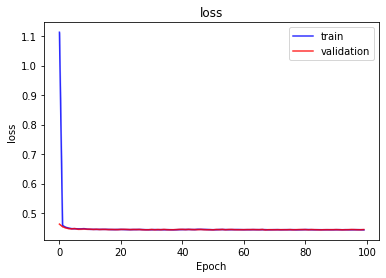

<b>bioma_loss</b>: 0.2213 (min: 0.2213, max: 0.2213)

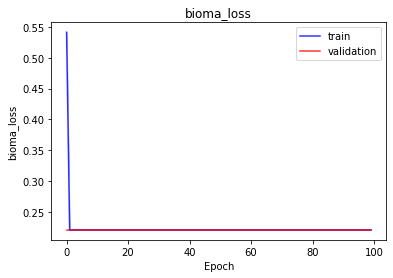

<b>domain_loss</b>: 0.2213 (min: 0.2213, max: 0.2213)

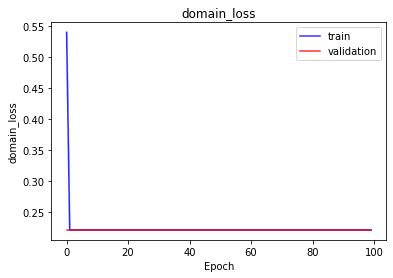

<b>latent_loss</b>: 0.0017 (min: 0.0017, max: 0.0017)

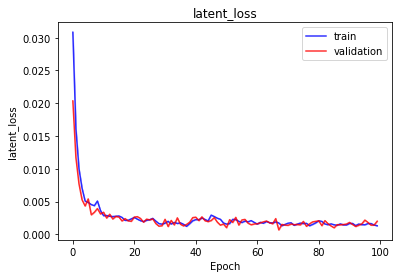

<b>bioma_mse</b>: 41528060.0000 (min: 41528060.0000, max: 41528060.0000)

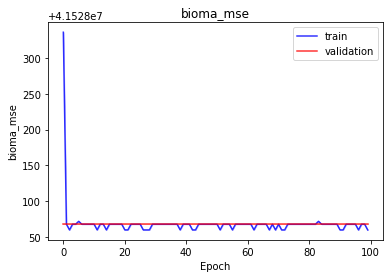

<b>bioma_mae</b>: 349.4747 (min: 349.4747, max: 349.4747)

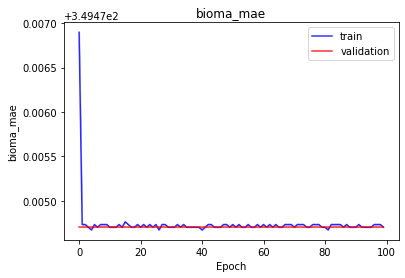

<b>bioma_mape</b>: 14.7800 (min: 14.7800, max: 14.7800)

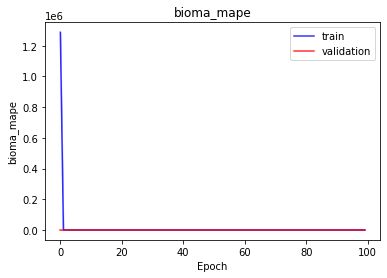

<b>bioma_BrayCurtis</b>: 0.2213 (min: 0.2213, max: 0.2213)

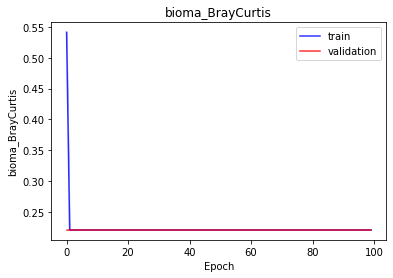

<b>bioma_pearson_corr</b>: 0.9556 (min: 0.9556, max: 0.9556)

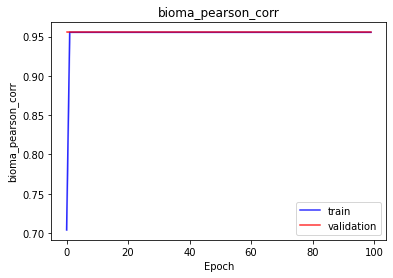

<b>bioma_jensen_shannon_divergence</b>: 4.7029 (min: 4.7029, max: 4.7029)

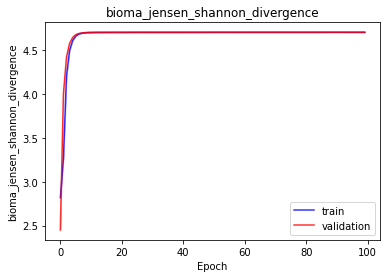

<b>domain_mse</b>: 41528060.0000 (min: 41528060.0000, max: 41528060.0000)

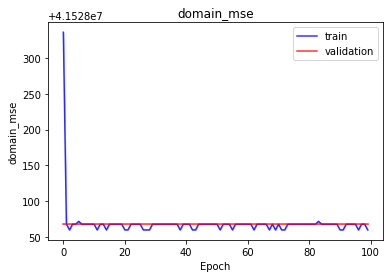

<b>domain_mae</b>: 349.4747 (min: 349.4747, max: 349.4747)

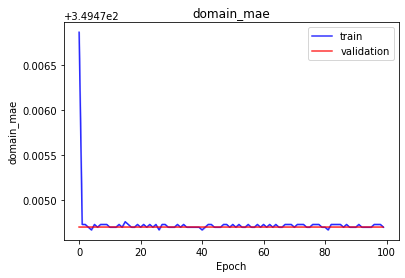

<b>domain_mape</b>: 14.7800 (min: 14.7800, max: 14.7800)

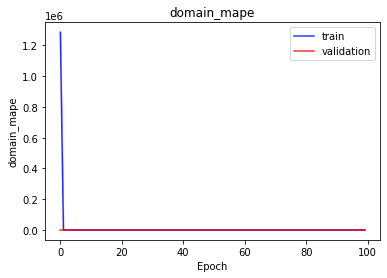

<b>domain_BrayCurtis</b>: 0.2213 (min: 0.2213, max: 0.2213)

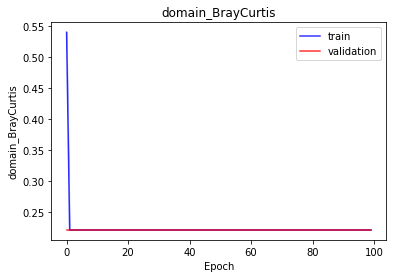

<b>domain_pearson_corr</b>: 0.9556 (min: 0.9556, max: 0.9556)

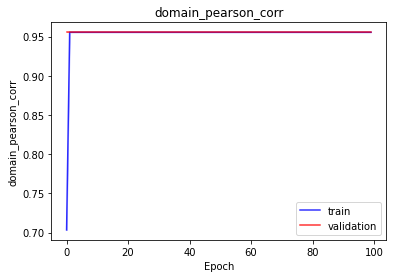

<b>domain_jensen_shannon_divergence</b>: 4.7029 (min: 4.7029, max: 4.7029)

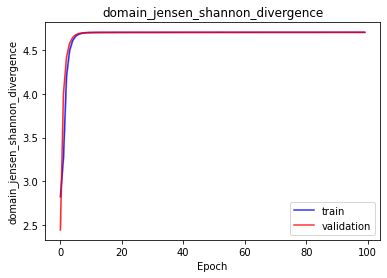

<b>latent_mae</b>: 0.0017 (min: 0.0017, max: 0.0017)

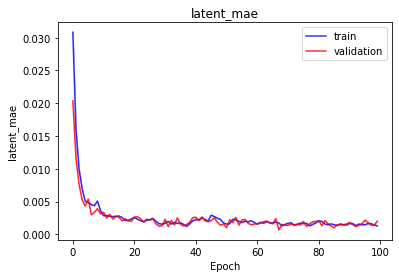

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.4442588984966278 | 0.4442588984966278 | 0.4442588984966278 |
| bioma_loss | 0.22126664221286774 | 0.22126664221286774 | 0.22126664221286774 |
| domain_loss | 0.22126664221286774 | 0.22126664221286774 | 0.22126664221286774 |
| latent_loss | 0.0017256384016945958 | 0.0017256384016945958 | 0.0017256384016945958 |
| bioma_mse | 41528060.0 | 41528060.0 | 41528060.0 |
| bioma_mae | 349.4747314453125 | 349.4747314453125 | 349.4747314453125 |
| bioma_mape | 14.779964447021484 | 14.779964447021484 | 14.779964447021484 |
| bioma_BrayCurtis | 0.22126664221286774 | 0.22126664221286774 | 0.22126664221286774 |
| bioma_pearson_corr | 0.9555656909942627 | 0.9555656909942627 | 0.9555656909942627 |
| bioma_jensen_shannon_divergence | 4.70294713973999 | 4.70294713973999 | 4.70294713973999 |
| domain_mse | 41528060.0 | 41528060.0 | 41528060.0 |
| domain_mae | 349.4747314453125 | 349.4747314453125 | 349.4747314453125 |
| domain_mape | 14.779964447021484 | 14.779964447021484 | 14.779964447021484 |
| domain_BrayCurtis | 0.22126664221286774 | 0.22126664221286774 | 0.22126664221286774 |
| domain_pearson_corr | 0.9555656909942627 | 0.9555656909942627 | 0.9555656909942627 |
| domain_jensen_shannon_divergence | 4.702915668487549 | 4.702915668487549 | 4.702915668487549 |
| latent_mae | 0.0017256384016945958 | 0.0017256384016945958 | 0.0017256384016945958 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.23275910317897797 | 0.23275910317897797 | 0.23275910317897797 |
| pearson_corr | 0.9532116055488586 | 0.9532116055488586 | 0.9532116055488586 |
| jensen_shannon_divergence | 4.980236053466797 | 4.980236053466797 | 4.980236053466797 |


In [27]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.01,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='softmax',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='softmax')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Family

In [28]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_familia/otus_familia_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_familia/metadatos_nutrientes_familia.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | softmax |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.01 |
| Optimizer | Adam |


<p>Best iteration: <b>22</b></p>

<b>loss</b>: 0.4062 (min: 0.4062, max: 0.4062)

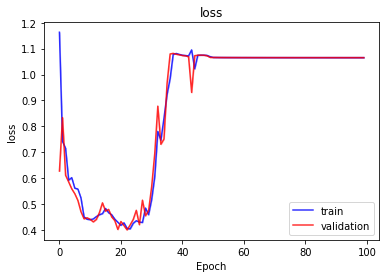

<b>bioma_loss</b>: 0.1103 (min: 0.1103, max: 0.1103)

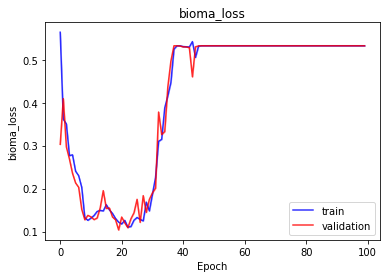

<b>domain_loss</b>: 0.2683 (min: 0.2683, max: 0.2683)

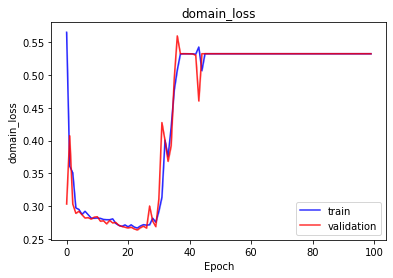

<b>latent_loss</b>: 0.0276 (min: 0.0276, max: 0.0276)

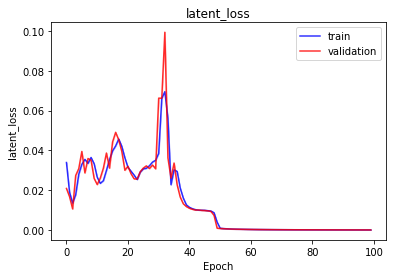

<b>bioma_mse</b>: 474642.6875 (min: 474642.6875, max: 474642.6875)

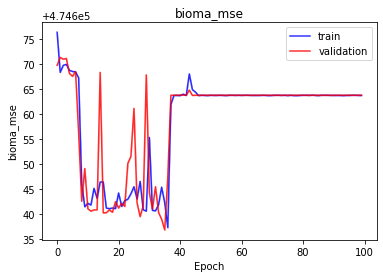

<b>bioma_mae</b>: 41.0593 (min: 41.0593, max: 41.0593)

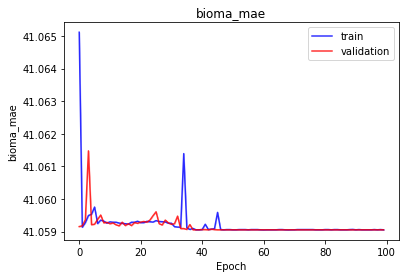

<b>bioma_mape</b>: 132169.5312 (min: 132169.5312, max: 132169.5312)

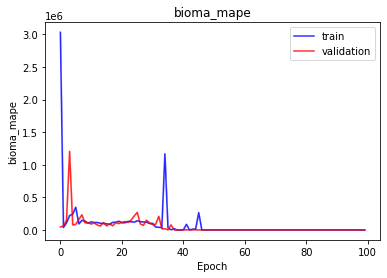

<b>bioma_BrayCurtis</b>: 0.1103 (min: 0.1103, max: 0.1103)

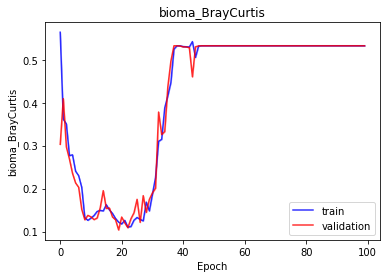

<b>bioma_pearson_corr</b>: 0.9699 (min: 0.9699, max: 0.9699)

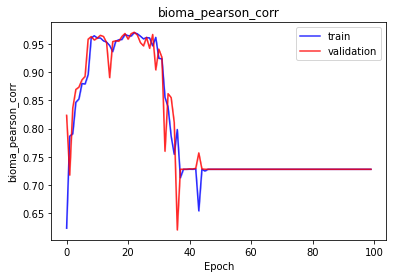

<b>bioma_jensen_shannon_divergence</b>: 0.2082 (min: 0.2082, max: 0.2082)

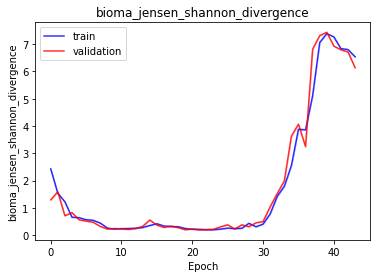

<b>domain_mse</b>: 474666.4062 (min: 474666.4062, max: 474666.4062)

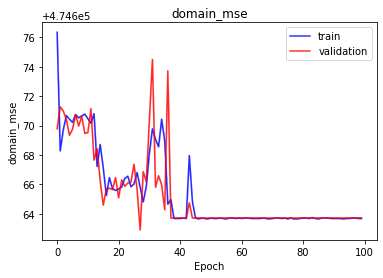

<b>domain_mae</b>: 41.0594 (min: 41.0594, max: 41.0594)

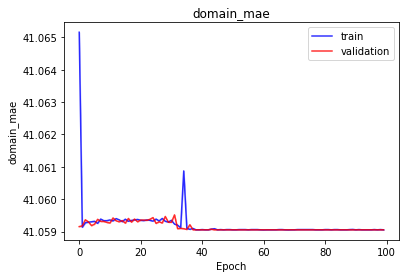

<b>domain_mape</b>: 154094.5312 (min: 154094.5312, max: 154094.5312)

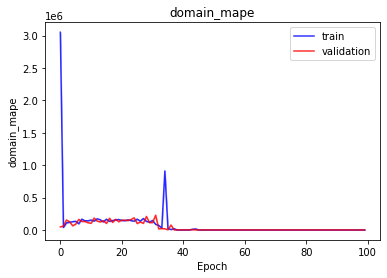

<b>domain_BrayCurtis</b>: 0.2683 (min: 0.2683, max: 0.2683)

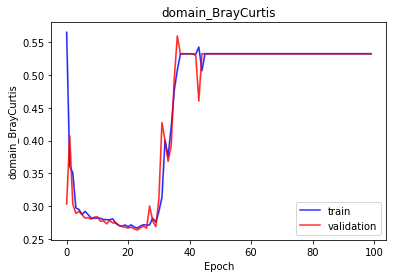

<b>domain_pearson_corr</b>: 0.8500 (min: 0.8500, max: 0.8500)

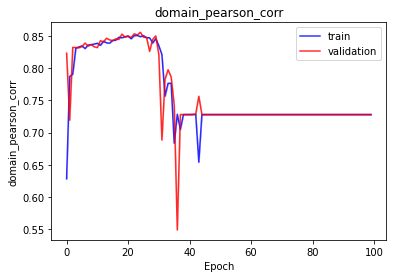

<b>domain_jensen_shannon_divergence</b>: 0.5372 (min: 0.5372, max: 0.5372)

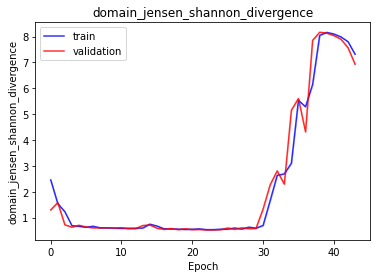

<b>latent_mae</b>: 0.0276 (min: 0.0276, max: 0.0276)

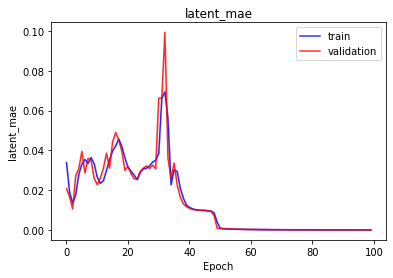

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.406203955411911 | 0.406203955411911 | 0.406203955411911 |
| bioma_loss | 0.11026695370674133 | 0.11026695370674133 | 0.11026695370674133 |
| domain_loss | 0.26828911900520325 | 0.26828911900520325 | 0.26828911900520325 |
| latent_loss | 0.027647873386740685 | 0.027647873386740685 | 0.027647873386740685 |
| bioma_mse | 474642.6875 | 474642.6875 | 474642.6875 |
| bioma_mae | 41.0593147277832 | 41.0593147277832 | 41.0593147277832 |
| bioma_mape | 132169.53125 | 132169.53125 | 132169.53125 |
| bioma_BrayCurtis | 0.11026695370674133 | 0.11026695370674133 | 0.11026695370674133 |
| bioma_pearson_corr | 0.9699237942695618 | 0.9699237942695618 | 0.9699237942695618 |
| bioma_jensen_shannon_divergence | 0.2081616371870041 | 0.2081616371870041 | 0.2081616371870041 |
| domain_mse | 474666.40625 | 474666.40625 | 474666.40625 |
| domain_mae | 41.05936050415039 | 41.05936050415039 | 41.05936050415039 |
| domain_mape | 154094.53125 | 154094.53125 | 154094.53125 |
| domain_BrayCurtis | 0.26828911900520325 | 0.26828911900520325 | 0.26828911900520325 |
| domain_pearson_corr | 0.8500449657440186 | 0.8500449657440186 | 0.8500449657440186 |
| domain_jensen_shannon_divergence | 0.5372453331947327 | 0.5372453331947327 | 0.5372453331947327 |
| latent_mae | 0.027647873386740685 | 0.027647873386740685 | 0.027647873386740685 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.48122403025627136 | 0.48122403025627136 | 0.48122403025627136 |
| pearson_corr | 0.8150383234024048 | 0.8150383234024048 | 0.8150383234024048 |
| jensen_shannon_divergence | nan | nan | nan |


In [29]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.01,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='softmax',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='softmax')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Order

In [30]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_orden/otus_orden_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_orden/metadatos_nutrientes_orden.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | softmax |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.01 |
| Optimizer | Adam |


<p>Best iteration: <b>94</b></p>

<b>loss</b>: 0.5676 (min: 0.5676, max: 0.5676)

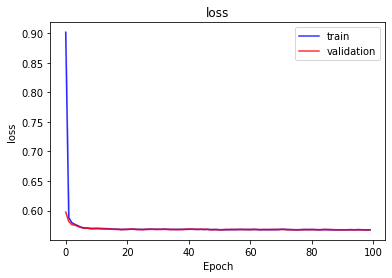

<b>bioma_loss</b>: 0.2833 (min: 0.2833, max: 0.2833)

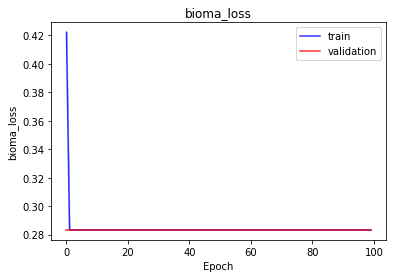

<b>domain_loss</b>: 0.2833 (min: 0.2833, max: 0.2833)

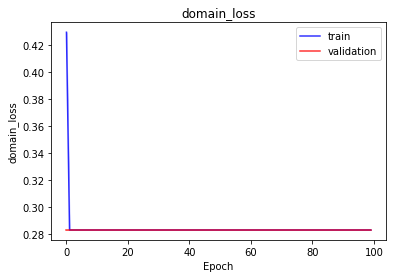

<b>latent_loss</b>: 0.0010 (min: 0.0010, max: 0.0010)

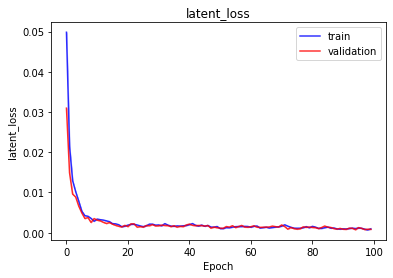

<b>bioma_mse</b>: 9804320.0000 (min: 9804320.0000, max: 9804320.0000)

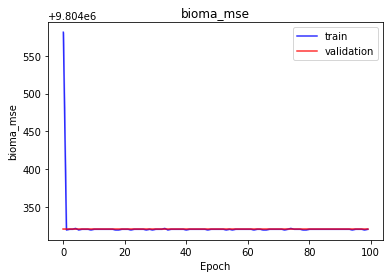

<b>bioma_mae</b>: 601.1545 (min: 601.1545, max: 601.1545)

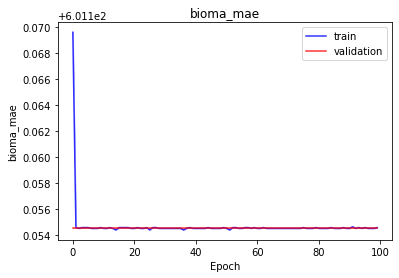

<b>bioma_mape</b>: 17.6940 (min: 17.6940, max: 17.6940)

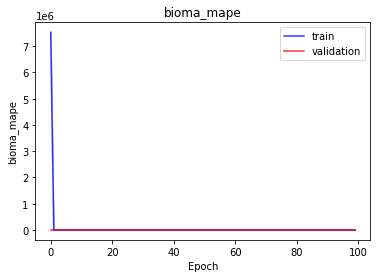

<b>bioma_BrayCurtis</b>: 0.2833 (min: 0.2833, max: 0.2833)

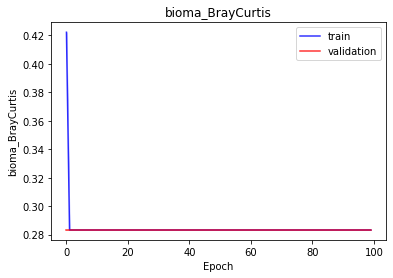

<b>bioma_pearson_corr</b>: 0.9040 (min: 0.9040, max: 0.9040)

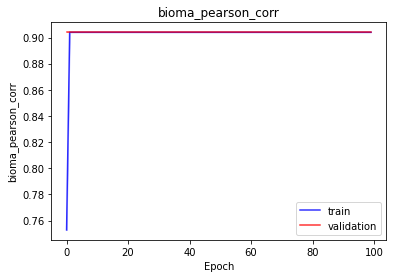

<b>bioma_jensen_shannon_divergence</b>: 6.1307 (min: 6.1307, max: 6.1307)

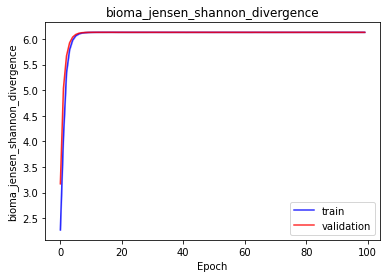

<b>domain_mse</b>: 9804320.0000 (min: 9804320.0000, max: 9804320.0000)

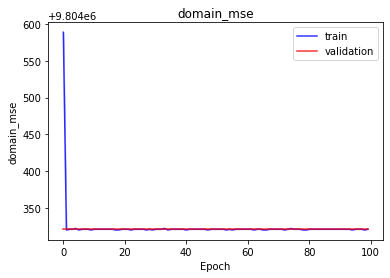

<b>domain_mae</b>: 601.1545 (min: 601.1545, max: 601.1545)

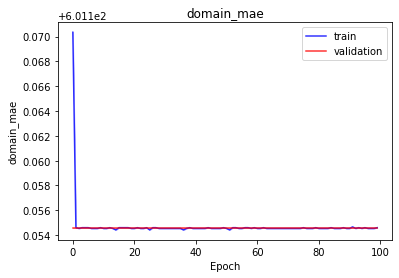

<b>domain_mape</b>: 17.6940 (min: 17.6940, max: 17.6940)

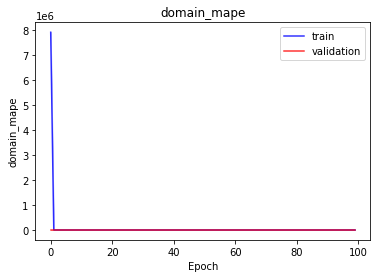

<b>domain_BrayCurtis</b>: 0.2833 (min: 0.2833, max: 0.2833)

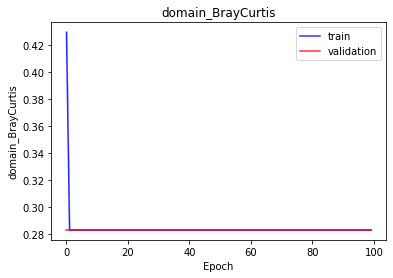

<b>domain_pearson_corr</b>: 0.9040 (min: 0.9040, max: 0.9040)

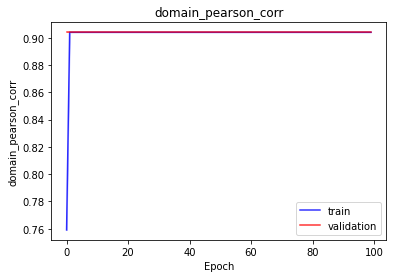

<b>domain_jensen_shannon_divergence</b>: 6.1308 (min: 6.1308, max: 6.1308)

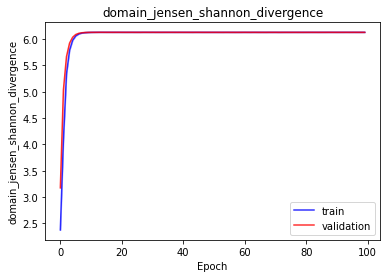

<b>latent_mae</b>: 0.0010 (min: 0.0010, max: 0.0010)

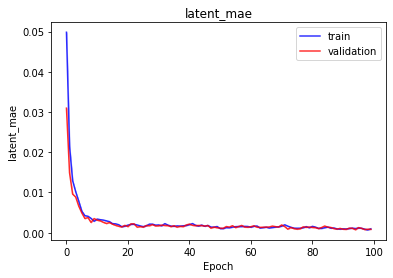

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.5676146745681763 | 0.5676146745681763 | 0.5676146745681763 |
| bioma_loss | 0.283288836479187 | 0.283288836479187 | 0.283288836479187 |
| domain_loss | 0.283288836479187 | 0.283288836479187 | 0.283288836479187 |
| latent_loss | 0.0010370900854468346 | 0.0010370900854468346 | 0.0010370900854468346 |
| bioma_mse | 9804320.0 | 9804320.0 | 9804320.0 |
| bioma_mae | 601.154541015625 | 601.154541015625 | 601.154541015625 |
| bioma_mape | 17.694042205810547 | 17.694042205810547 | 17.694042205810547 |
| bioma_BrayCurtis | 0.283288836479187 | 0.283288836479187 | 0.283288836479187 |
| bioma_pearson_corr | 0.9040219783782959 | 0.9040219783782959 | 0.9040219783782959 |
| bioma_jensen_shannon_divergence | 6.130747318267822 | 6.130747318267822 | 6.130747318267822 |
| domain_mse | 9804320.0 | 9804320.0 | 9804320.0 |
| domain_mae | 601.154541015625 | 601.154541015625 | 601.154541015625 |
| domain_mape | 17.694042205810547 | 17.694042205810547 | 17.694042205810547 |
| domain_BrayCurtis | 0.283288836479187 | 0.283288836479187 | 0.283288836479187 |
| domain_pearson_corr | 0.9040219783782959 | 0.9040219783782959 | 0.9040219783782959 |
| domain_jensen_shannon_divergence | 6.1307501792907715 | 6.1307501792907715 | 6.1307501792907715 |
| latent_mae | 0.0010370900854468346 | 0.0010370900854468346 | 0.0010370900854468346 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2768914997577667 | 0.2768914997577667 | 0.2768914997577667 |
| pearson_corr | 0.9104400873184204 | 0.9104400873184204 | 0.9104400873184204 |
| jensen_shannon_divergence | 6.027015209197998 | 6.027015209197998 | 6.027015209197998 |


In [31]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.01,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='softmax',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='softmax')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Class

In [32]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_clase/otus_clase_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_clase/metadatos_nutrientes_clase.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | softmax |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.01 |
| Optimizer | Adam |


<p>Best iteration: <b>88</b></p>

<b>loss</b>: 0.7879 (min: 0.7879, max: 0.7879)

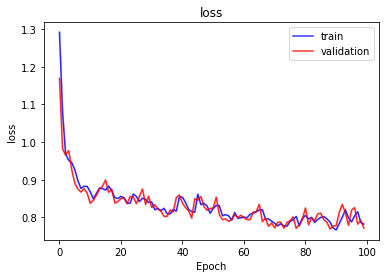

<b>bioma_loss</b>: 0.2104 (min: 0.2104, max: 0.2104)

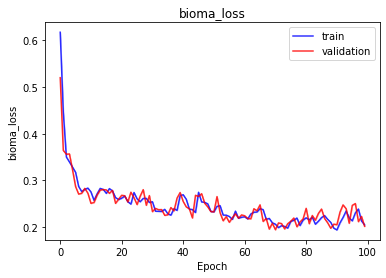

<b>domain_loss</b>: 0.5502 (min: 0.5502, max: 0.5502)

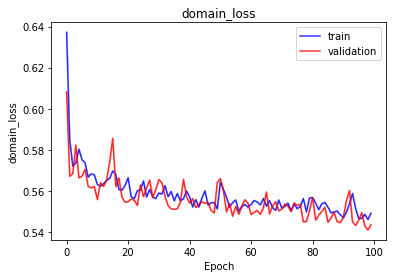

<b>latent_loss</b>: 0.0273 (min: 0.0273, max: 0.0273)

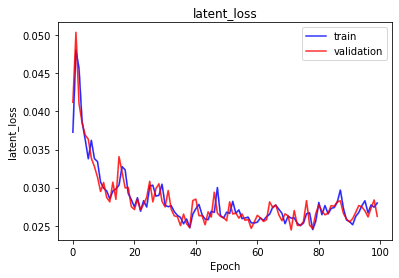

<b>bioma_mse</b>: 12.0858 (min: 12.0858, max: 12.0858)

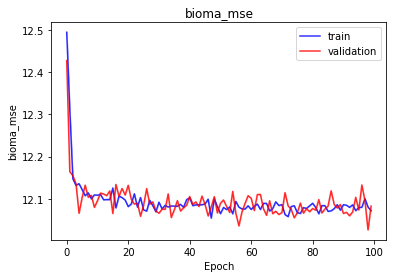

<b>bioma_mae</b>: 0.9299 (min: 0.9299, max: 0.9299)

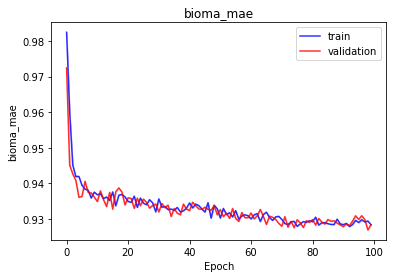

<b>bioma_mape</b>: 10796636.0000 (min: 10796636.0000, max: 10796636.0000)

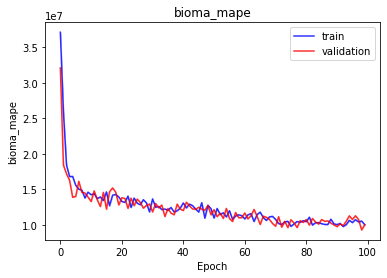

<b>bioma_BrayCurtis</b>: 0.2104 (min: 0.2104, max: 0.2104)

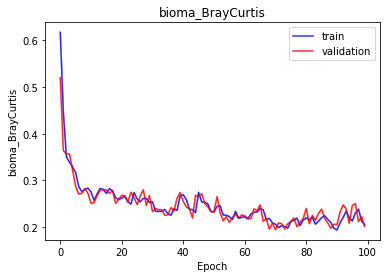

<b>bioma_pearson_corr</b>: 0.8825 (min: 0.8825, max: 0.8825)

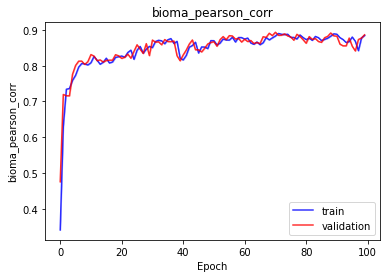

<b>bioma_jensen_shannon_divergence</b>: 0.9331 (min: 0.9331, max: 0.9331)

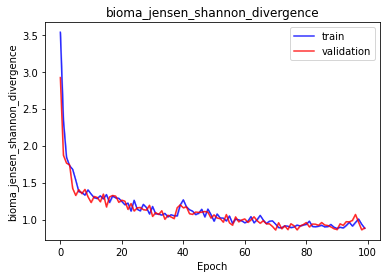

<b>domain_mse</b>: 12.4295 (min: 12.4295, max: 12.4295)

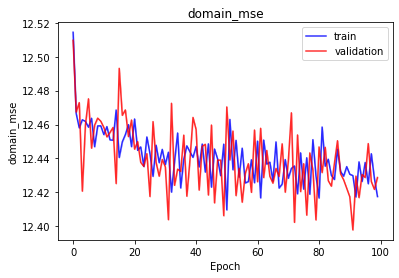

<b>domain_mae</b>: 0.9754 (min: 0.9754, max: 0.9754)

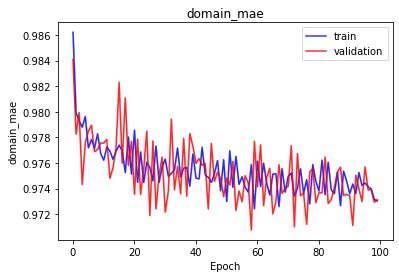

<b>domain_mape</b>: 33542476.0000 (min: 33542476.0000, max: 33542476.0000)

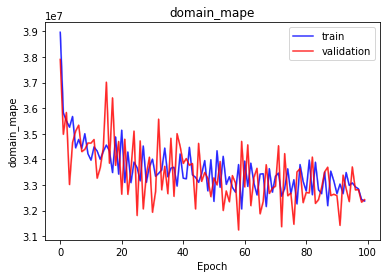

<b>domain_BrayCurtis</b>: 0.5502 (min: 0.5502, max: 0.5502)

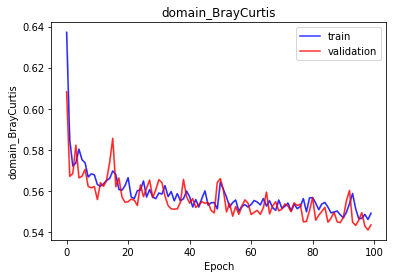

<b>domain_pearson_corr</b>: 0.4607 (min: 0.4607, max: 0.4607)

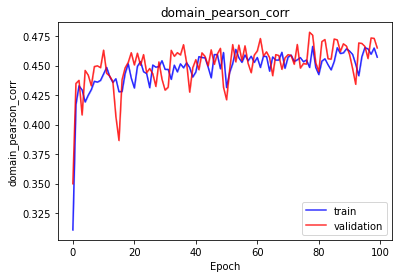

<b>domain_jensen_shannon_divergence</b>: 3.1320 (min: 3.1320, max: 3.1320)

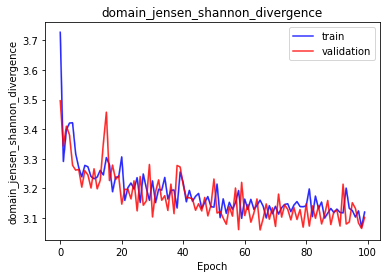

<b>latent_mae</b>: 0.0273 (min: 0.0273, max: 0.0273)

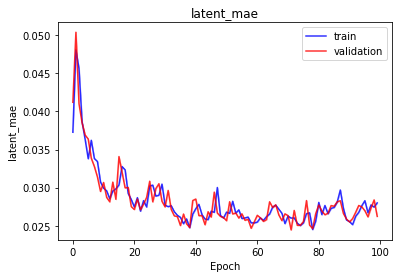

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.7879069447517395 | 0.7879069447517395 | 0.7879069447517395 |
| bioma_loss | 0.2103966623544693 | 0.2103966623544693 | 0.2103966623544693 |
| domain_loss | 0.5502142906188965 | 0.5502142906188965 | 0.5502142906188965 |
| latent_loss | 0.02729608491063118 | 0.02729608491063118 | 0.02729608491063118 |
| bioma_mse | 12.085845947265625 | 12.085845947265625 | 12.085845947265625 |
| bioma_mae | 0.9298772811889648 | 0.9298772811889648 | 0.9298772811889648 |
| bioma_mape | 10796636.0 | 10796636.0 | 10796636.0 |
| bioma_BrayCurtis | 0.2103966623544693 | 0.2103966623544693 | 0.2103966623544693 |
| bioma_pearson_corr | 0.8825297951698303 | 0.8825297951698303 | 0.8825297951698303 |
| bioma_jensen_shannon_divergence | 0.9331371784210205 | 0.9331371784210205 | 0.9331371784210205 |
| domain_mse | 12.429534912109375 | 12.429534912109375 | 12.429534912109375 |
| domain_mae | 0.9753689169883728 | 0.9753689169883728 | 0.9753689169883728 |
| domain_mape | 33542476.0 | 33542476.0 | 33542476.0 |
| domain_BrayCurtis | 0.5502142906188965 | 0.5502142906188965 | 0.5502142906188965 |
| domain_pearson_corr | 0.460720956325531 | 0.460720956325531 | 0.460720956325531 |
| domain_jensen_shannon_divergence | 3.13197922706604 | 3.13197922706604 | 3.13197922706604 |
| latent_mae | 0.02729608491063118 | 0.02729608491063118 | 0.02729608491063118 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.6176183819770813 | 0.6176183819770813 | 0.6176183819770813 |
| pearson_corr | 0.39009740948677063 | 0.39009740948677063 | 0.39009740948677063 |
| jensen_shannon_divergence | 3.6230881214141846 | 3.6230881214141846 | 3.6230881214141846 |


In [33]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.01,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='softmax',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='softmax')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Phylum

In [34]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_filo/otus_filo_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_filo/metadatos_nutrientes_filo.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | softmax |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.01 |
| Optimizer | Adam |


<p>Best iteration: <b>98</b></p>

<b>loss</b>: 0.1990 (min: 0.1990, max: 0.1990)

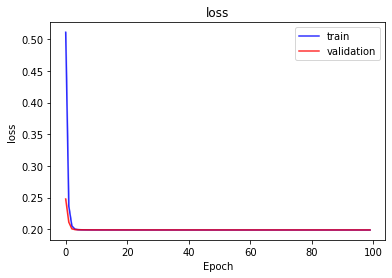

<b>bioma_loss</b>: 0.0995 (min: 0.0995, max: 0.0995)

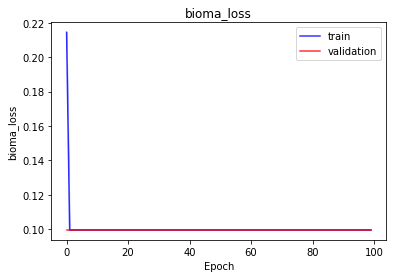

<b>domain_loss</b>: 0.0995 (min: 0.0995, max: 0.0995)

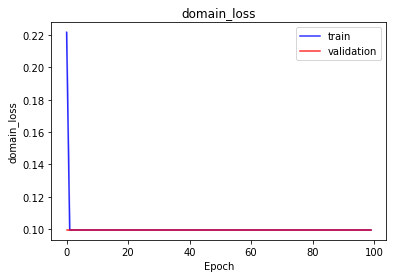

<b>latent_loss</b>: 0.0000 (min: 0.0000, max: 0.0000)

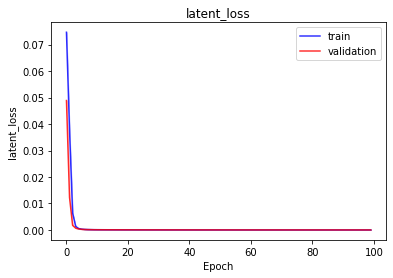

<b>bioma_mse</b>: 134845.0469 (min: 134845.0469, max: 134845.0469)

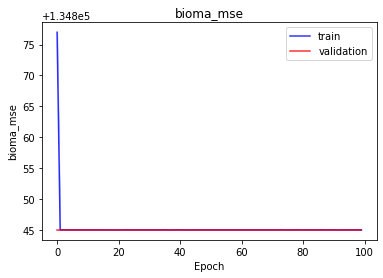

<b>bioma_mae</b>: 118.1727 (min: 118.1727, max: 118.1727)

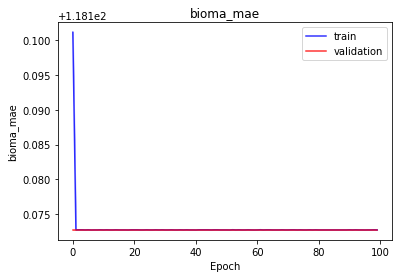

<b>bioma_mape</b>: 356179.3750 (min: 356179.3750, max: 356179.3750)

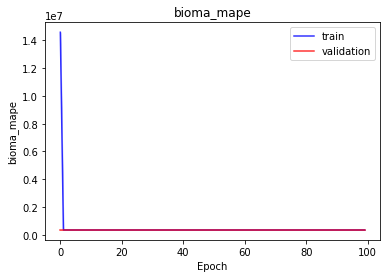

<b>bioma_BrayCurtis</b>: 0.0995 (min: 0.0995, max: 0.0995)

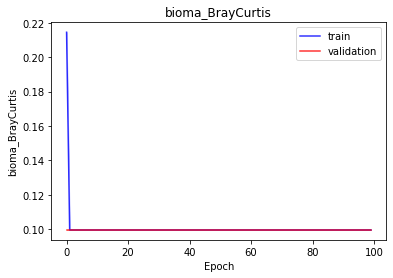

<b>bioma_pearson_corr</b>: 0.9778 (min: 0.9778, max: 0.9778)

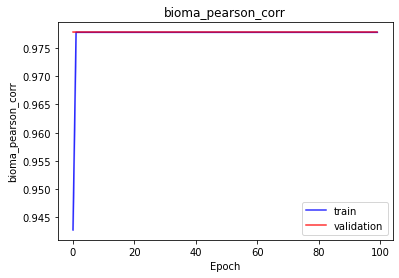

<b>bioma_jensen_shannon_divergence</b>: 3.6452 (min: 3.6452, max: 3.6452)

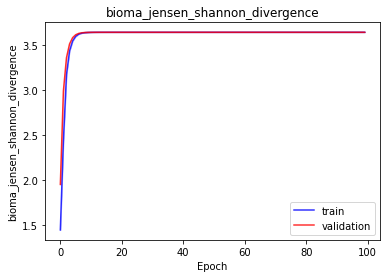

<b>domain_mse</b>: 134845.0469 (min: 134845.0469, max: 134845.0469)

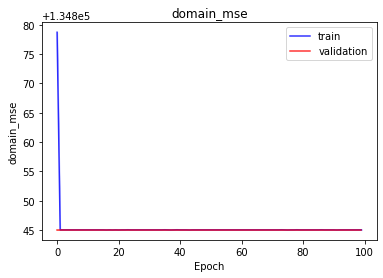

<b>domain_mae</b>: 118.1727 (min: 118.1727, max: 118.1727)

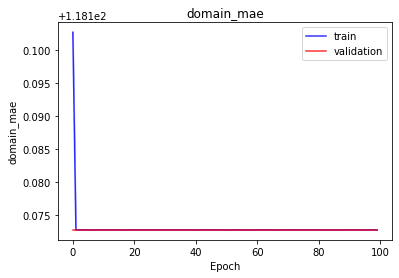

<b>domain_mape</b>: 356179.3750 (min: 356179.3750, max: 356179.3750)

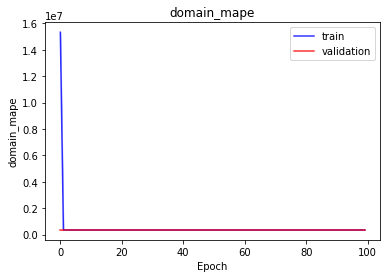

<b>domain_BrayCurtis</b>: 0.0995 (min: 0.0995, max: 0.0995)

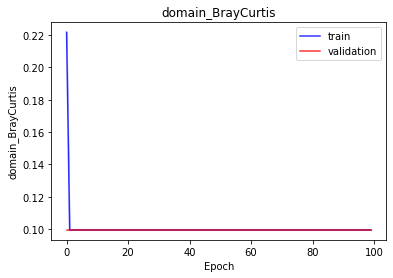

<b>domain_pearson_corr</b>: 0.9778 (min: 0.9778, max: 0.9778)

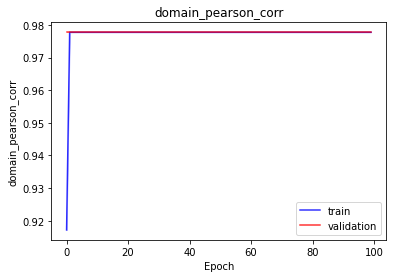

<b>domain_jensen_shannon_divergence</b>: 3.6452 (min: 3.6452, max: 3.6452)

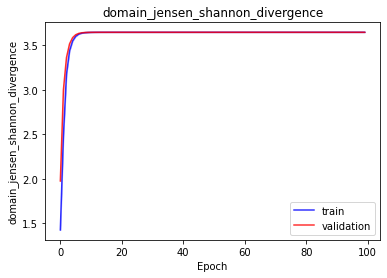

<b>latent_mae</b>: 0.0000 (min: 0.0000, max: 0.0000)

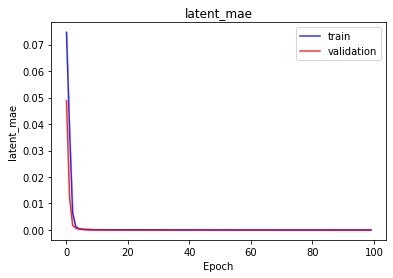

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.19902856647968292 | 0.19902856647968292 | 0.19902856647968292 |
| bioma_loss | 0.09951116144657135 | 0.09951116144657135 | 0.09951116144657135 |
| domain_loss | 0.09951116144657135 | 0.09951116144657135 | 0.09951116144657135 |
| latent_loss | 6.247352303034859e-06 | 6.247352303034859e-06 | 6.247352303034859e-06 |
| bioma_mse | 134845.046875 | 134845.046875 | 134845.046875 |
| bioma_mae | 118.1727294921875 | 118.1727294921875 | 118.1727294921875 |
| bioma_mape | 356179.375 | 356179.375 | 356179.375 |
| bioma_BrayCurtis | 0.09951116144657135 | 0.09951116144657135 | 0.09951116144657135 |
| bioma_pearson_corr | 0.9777647256851196 | 0.9777647256851196 | 0.9777647256851196 |
| bioma_jensen_shannon_divergence | 3.6452364921569824 | 3.6452364921569824 | 3.6452364921569824 |
| domain_mse | 134845.046875 | 134845.046875 | 134845.046875 |
| domain_mae | 118.1727294921875 | 118.1727294921875 | 118.1727294921875 |
| domain_mape | 356179.375 | 356179.375 | 356179.375 |
| domain_BrayCurtis | 0.09951116144657135 | 0.09951116144657135 | 0.09951116144657135 |
| domain_pearson_corr | 0.9777647256851196 | 0.9777647256851196 | 0.9777647256851196 |
| domain_jensen_shannon_divergence | 3.645236015319824 | 3.645236015319824 | 3.645236015319824 |
| latent_mae | 6.247352303034859e-06 | 6.247352303034859e-06 | 6.247352303034859e-06 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.11989408731460571 | 0.11989408731460571 | 0.11989408731460571 |
| pearson_corr | 0.9541983008384705 | 0.9541983008384705 | 0.9541983008384705 |
| jensen_shannon_divergence | 4.509006023406982 | 4.509006023406982 | 4.509006023406982 |


In [35]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.01,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='softmax',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='softmax')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Kingdom

In [ ]:
????????????????Lo hago?

--------------------------
# 44 variables Latent OTU

### Genus

In [36]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_genero/otus_genero_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_genero/metadatos_nutrientes_genero.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>1</b></p>

<b>loss</b>: 0.7296 (min: 0.7296, max: 0.7296)

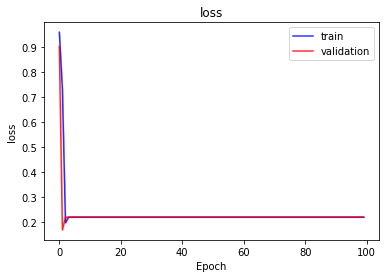

<b>bioma_mse</b>: 41528552.0000 (min: 41528552.0000, max: 41528552.0000)

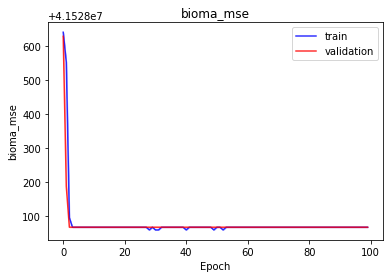

<b>bioma_mae</b>: 349.4777 (min: 349.4777, max: 349.4777)

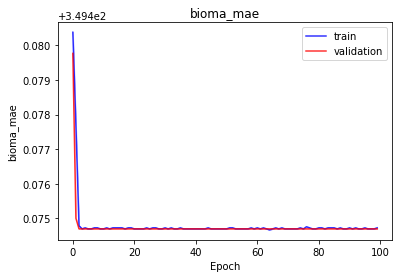

<b>bioma_mape</b>: 1842609.5000 (min: 1842609.5000, max: 1842609.5000)

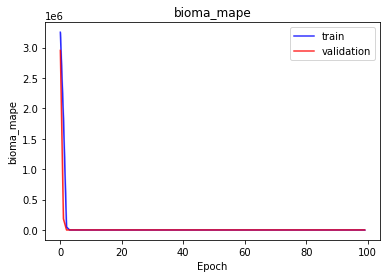

<b>bioma_BrayCurtis</b>: 0.7296 (min: 0.7296, max: 0.7296)

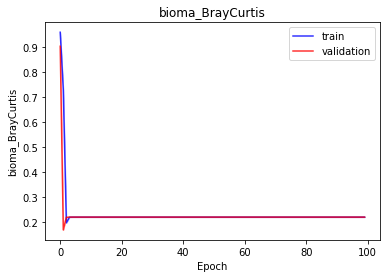

<b>bioma_pearson_corr</b>: 0.5791 (min: 0.5791, max: 0.5791)

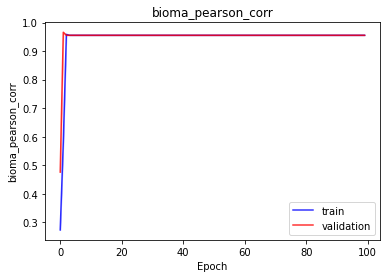

<b>bioma_jensen_shannon_divergence</b>: 3.1039 (min: 3.1039, max: 3.1039)

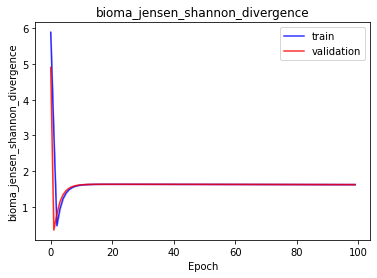

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.7295624017715454 | 0.7295624017715454 | 0.7295624017715454 |
| bioma_mse | 41528552.0 | 41528552.0 | 41528552.0 |
| bioma_mae | 349.4776916503906 | 349.4776916503906 | 349.4776916503906 |
| bioma_mape | 1842609.5 | 1842609.5 | 1842609.5 |
| bioma_BrayCurtis | 0.7295624017715454 | 0.7295624017715454 | 0.7295624017715454 |
| bioma_pearson_corr | 0.5791307091712952 | 0.5791307091712952 | 0.5791307091712952 |
| bioma_jensen_shannon_divergence | 3.1038503646850586 | 3.1038503646850586 | 3.1038503646850586 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.23275858163833618 | 0.23275858163833618 | 0.23275858163833618 |
| pearson_corr | 0.9532116651535034 | 0.9532116651535034 | 0.9532116651535034 |
| jensen_shannon_divergence | 1.7455238103866577 | 1.7455238103866577 | 1.7455238103866577 |


In [37]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='softmax')(in_layer)
    net = layers.Dense(64, activation='softmax')(net)
    net = layers.Dense(32, activation='softmax')(net)
    net = layers.Dense(16, activation='softmax')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Family

In [38]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_familia/otus_familia_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_familia/metadatos_nutrientes_familia.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>93</b></p>

<b>loss</b>: 0.0481 (min: 0.0481, max: 0.0481)

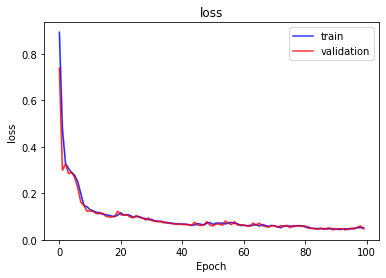

<b>bioma_mse</b>: 474642.1875 (min: 474642.1875, max: 474642.1875)

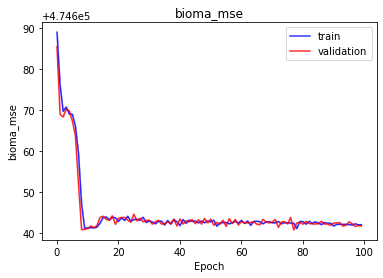

<b>bioma_mae</b>: 41.0592 (min: 41.0592, max: 41.0592)

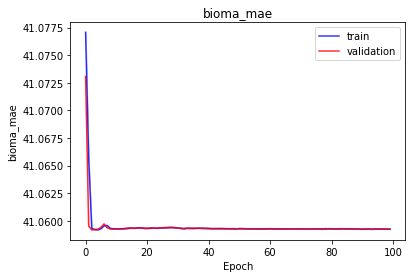

<b>bioma_mape</b>: 94407.1406 (min: 94407.1406, max: 94407.1406)

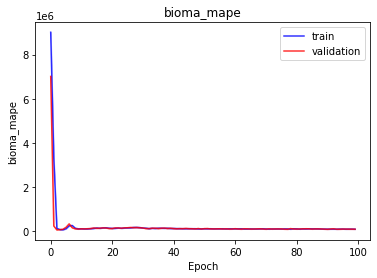

<b>bioma_BrayCurtis</b>: 0.0481 (min: 0.0481, max: 0.0481)

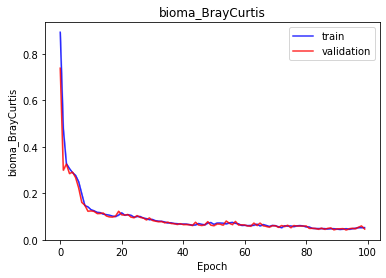

<b>bioma_pearson_corr</b>: 0.9937 (min: 0.9937, max: 0.9937)

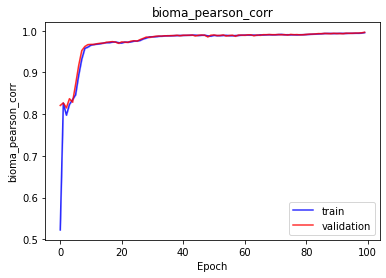

<b>bioma_jensen_shannon_divergence</b>: 0.0929 (min: 0.0929, max: 0.0929)

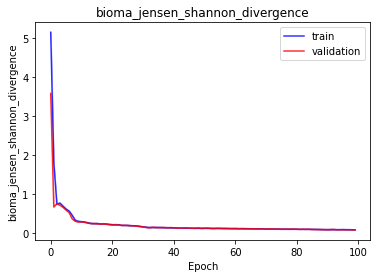

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.04808412119746208 | 0.04808412119746208 | 0.04808412119746208 |
| bioma_mse | 474642.1875 | 474642.1875 | 474642.1875 |
| bioma_mae | 41.05924606323242 | 41.05924606323242 | 41.05924606323242 |
| bioma_mape | 94407.140625 | 94407.140625 | 94407.140625 |
| bioma_BrayCurtis | 0.04808412119746208 | 0.04808412119746208 | 0.04808412119746208 |
| bioma_pearson_corr | 0.9936638474464417 | 0.9936638474464417 | 0.9936638474464417 |
| bioma_jensen_shannon_divergence | 0.09285423159599304 | 0.09285423159599304 | 0.09285423159599304 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.20378245413303375 | 0.20378245413303375 | 0.20378245413303375 |
| pearson_corr | 0.9188422560691833 | 0.9188422560691833 | 0.9188422560691833 |
| jensen_shannon_divergence | 0.3592936396598816 | 0.3592936396598816 | 0.3592936396598816 |


In [39]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='softmax')(in_layer)
    net = layers.Dense(64, activation='softmax')(net)
    net = layers.Dense(32, activation='softmax')(net)
    net = layers.Dense(16, activation='softmax')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Order

In [40]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_orden/otus_orden_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_orden/metadatos_nutrientes_orden.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>83</b></p>

<b>loss</b>: 0.0106 (min: 0.0106, max: 0.0106)

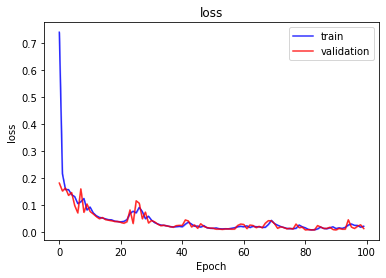

<b>bioma_mse</b>: 9804446.0000 (min: 9804446.0000, max: 9804446.0000)

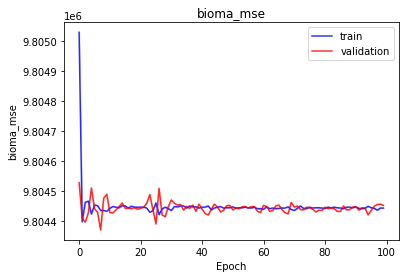

<b>bioma_mae</b>: 601.1546 (min: 601.1546, max: 601.1546)

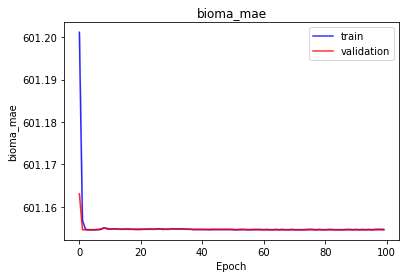

<b>bioma_mape</b>: 43394.6289 (min: 43394.6289, max: 43394.6289)

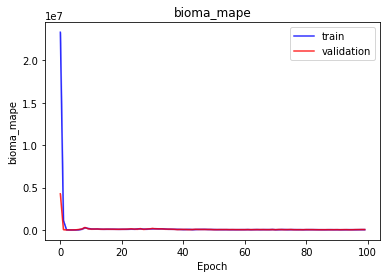

<b>bioma_BrayCurtis</b>: 0.0106 (min: 0.0106, max: 0.0106)

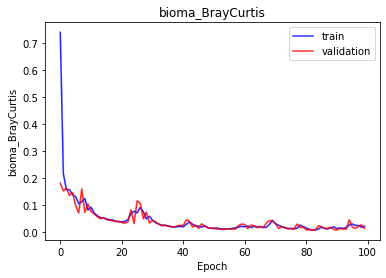

<b>bioma_pearson_corr</b>: 0.9997 (min: 0.9997, max: 0.9997)

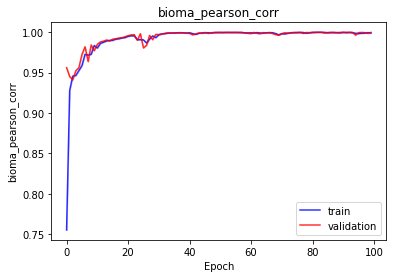

<b>bioma_jensen_shannon_divergence</b>: 0.0087 (min: 0.0087, max: 0.0087)

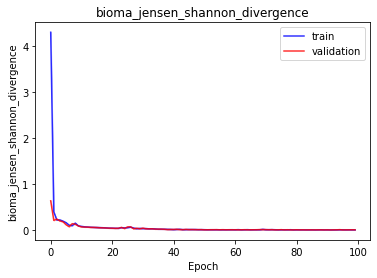

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.01056313794106245 | 0.01056313794106245 | 0.01056313794106245 |
| bioma_mse | 9804446.0 | 9804446.0 | 9804446.0 |
| bioma_mae | 601.1546020507812 | 601.1546020507812 | 601.1546020507812 |
| bioma_mape | 43394.62890625 | 43394.62890625 | 43394.62890625 |
| bioma_BrayCurtis | 0.01056313794106245 | 0.01056313794106245 | 0.01056313794106245 |
| bioma_pearson_corr | 0.9997445344924927 | 0.9997445344924927 | 0.9997445344924927 |
| bioma_jensen_shannon_divergence | 0.008702774532139301 | 0.008702774532139301 | 0.008702774532139301 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.13688793778419495 | 0.13688793778419495 | 0.13688793778419495 |
| pearson_corr | 0.9657647013664246 | 0.9657647013664246 | 0.9657647013664246 |
| jensen_shannon_divergence | 0.10638217628002167 | 0.10638217628002167 | 0.10638217628002167 |


In [41]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='softmax')(in_layer)
    net = layers.Dense(64, activation='softmax')(net)
    net = layers.Dense(32, activation='softmax')(net)
    net = layers.Dense(16, activation='softmax')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Class

In [42]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_clase/otus_clase_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_clase/metadatos_nutrientes_clase.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>92</b></p>

<b>loss</b>: 0.1321 (min: 0.1321, max: 0.1321)

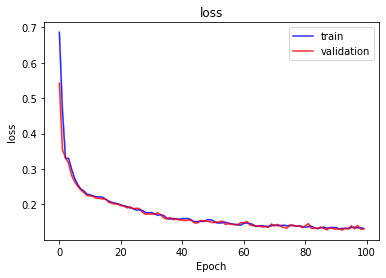

<b>bioma_mse</b>: 12.0700 (min: 12.0700, max: 12.0700)

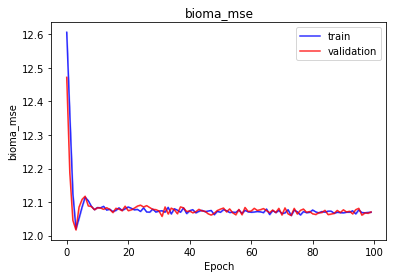

<b>bioma_mae</b>: 0.9227 (min: 0.9227, max: 0.9227)

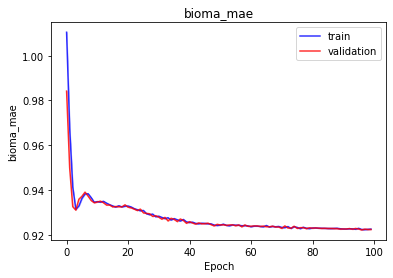

<b>bioma_mape</b>: 7191918.5000 (min: 7191918.5000, max: 7191918.5000)

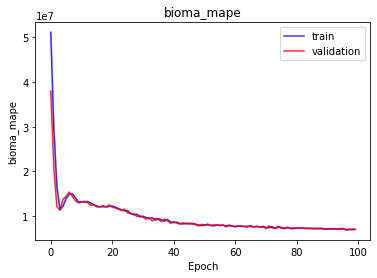

<b>bioma_BrayCurtis</b>: 0.1321 (min: 0.1321, max: 0.1321)

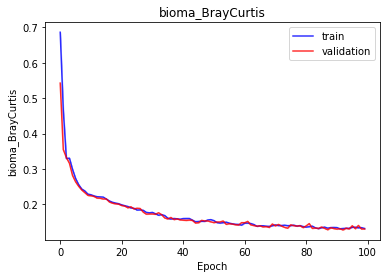

<b>bioma_pearson_corr</b>: 0.9121 (min: 0.9121, max: 0.9121)

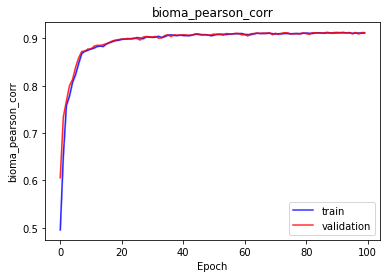

<b>bioma_jensen_shannon_divergence</b>: 0.6596 (min: 0.6596, max: 0.6596)

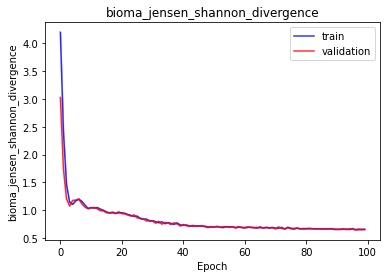

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.132061168551445 | 0.132061168551445 | 0.132061168551445 |
| bioma_mse | 12.069972038269043 | 12.069972038269043 | 12.069972038269043 |
| bioma_mae | 0.9226678013801575 | 0.9226678013801575 | 0.9226678013801575 |
| bioma_mape | 7191918.5 | 7191918.5 | 7191918.5 |
| bioma_BrayCurtis | 0.132061168551445 | 0.132061168551445 | 0.132061168551445 |
| bioma_pearson_corr | 0.9121382236480713 | 0.9121382236480713 | 0.9121382236480713 |
| bioma_jensen_shannon_divergence | 0.6596396565437317 | 0.6596396565437317 | 0.6596396565437317 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.6026512980461121 | 0.6026512980461121 | 0.6026512980461121 |
| pearson_corr | 0.4277322590351105 | 0.4277322590351105 | 0.4277322590351105 |
| jensen_shannon_divergence | 3.4262542724609375 | 3.4262542724609375 | 3.4262542724609375 |


In [43]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='softmax')(in_layer)
    net = layers.Dense(64, activation='softmax')(net)
    net = layers.Dense(32, activation='softmax')(net)
    net = layers.Dense(16, activation='softmax')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Phylum

In [44]:
nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
#nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_filo/otus_filo_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_filo/metadatos_nutrientes_filo.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 96 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>0</b></p>

<b>loss</b>: 0.4493 (min: 0.4493, max: 0.4493)

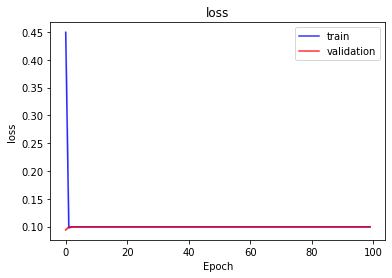

<b>bioma_mse</b>: 134956.7812 (min: 134956.7812, max: 134956.7812)

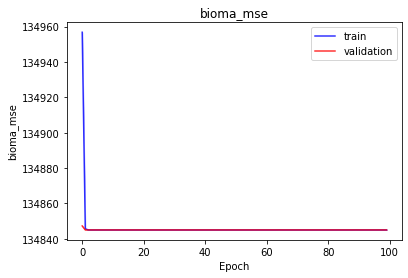

<b>bioma_mae</b>: 118.2624 (min: 118.2624, max: 118.2624)

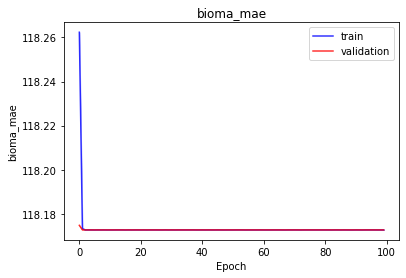

<b>bioma_mape</b>: 45188240.0000 (min: 45188240.0000, max: 45188240.0000)

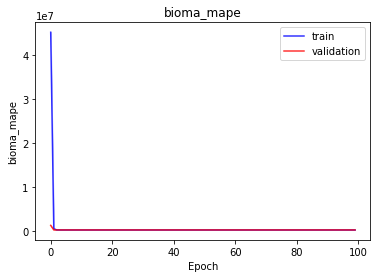

<b>bioma_BrayCurtis</b>: 0.4493 (min: 0.4493, max: 0.4493)

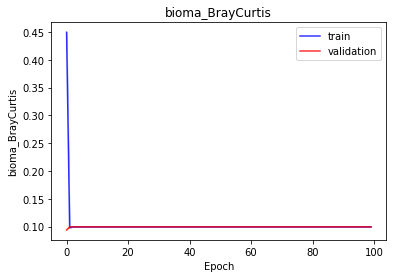

<b>bioma_pearson_corr</b>: 0.8437 (min: 0.8437, max: 0.8437)

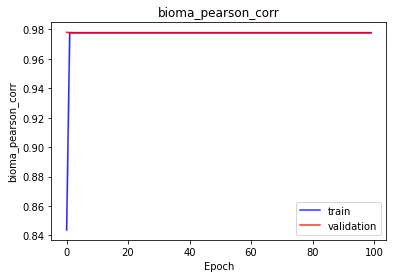

<b>bioma_jensen_shannon_divergence</b>: 2.1086 (min: 2.1086, max: 2.1086)

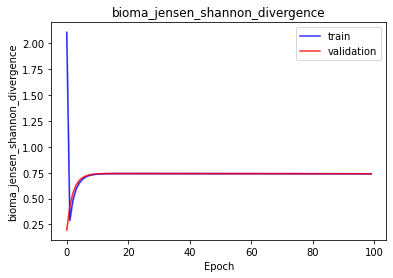

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.4493412375450134 | 0.4493412375450134 | 0.4493412375450134 |
| bioma_mse | 134956.78125 | 134956.78125 | 134956.78125 |
| bioma_mae | 118.26237487792969 | 118.26237487792969 | 118.26237487792969 |
| bioma_mape | 45188240.0 | 45188240.0 | 45188240.0 |
| bioma_BrayCurtis | 0.4493412375450134 | 0.4493412375450134 | 0.4493412375450134 |
| bioma_pearson_corr | 0.8437247276306152 | 0.8437247276306152 | 0.8437247276306152 |
| bioma_jensen_shannon_divergence | 2.1085915565490723 | 2.1085915565490723 | 2.1085915565490723 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.11989400535821915 | 0.11989400535821915 | 0.11989400535821915 |
| pearson_corr | 0.9541984796524048 | 0.9541984796524048 | 0.9541984796524048 |
| jensen_shannon_divergence | 0.9396345019340515 | 0.9396345019340515 | 0.9396345019340515 |


In [45]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=96,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=None,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='softmax')(in_layer)
    net = layers.Dense(64, activation='softmax')(net)
    net = layers.Dense(32, activation='softmax')(net)
    net = layers.Dense(16, activation='softmax')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Kingdom

In [ ]:
????????????????Lo hago?

--------------------------
--------------------------
# 22 variables Latent Combined

### Genus

In [46]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_genero/otus_genero_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_genero/metadatos_nutrientes_genero.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>94</b></p>

<b>loss</b>: 0.3107 (min: 0.3107, max: 0.3107)

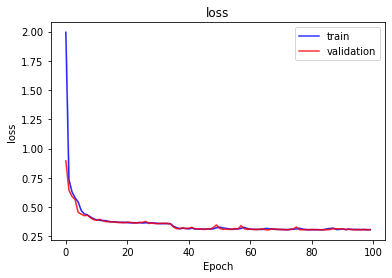

<b>bioma_loss</b>: 0.1528 (min: 0.1528, max: 0.1528)

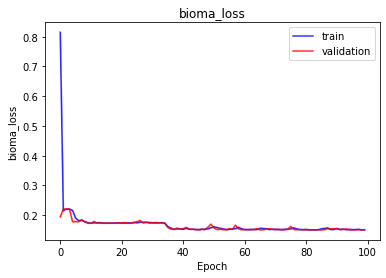

<b>domain_loss</b>: 0.1528 (min: 0.1528, max: 0.1528)

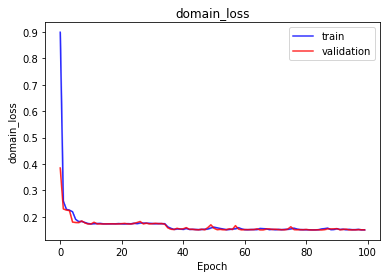

<b>latent_loss</b>: 0.0051 (min: 0.0051, max: 0.0051)

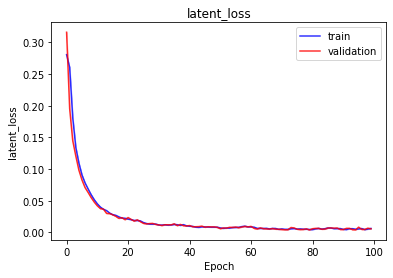

<b>bioma_mse</b>: 41528140.0000 (min: 41528140.0000, max: 41528140.0000)

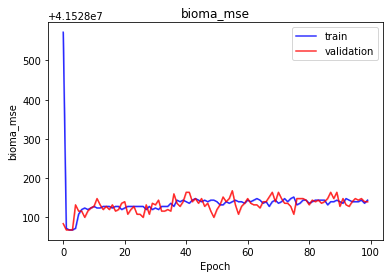

<b>bioma_mae</b>: 349.4747 (min: 349.4747, max: 349.4747)

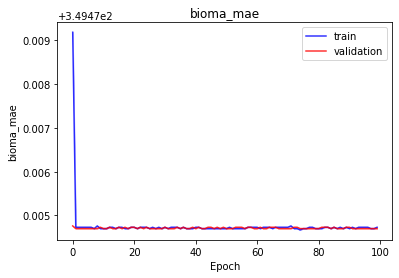

<b>bioma_mape</b>: 562.0510 (min: 562.0510, max: 562.0510)

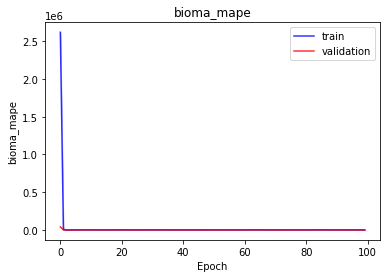

<b>bioma_BrayCurtis</b>: 0.1528 (min: 0.1528, max: 0.1528)

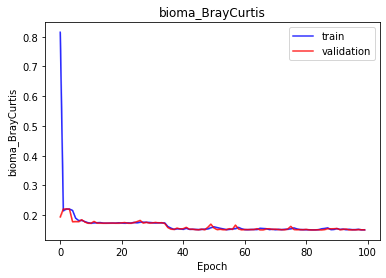

<b>bioma_pearson_corr</b>: 0.9644 (min: 0.9644, max: 0.9644)

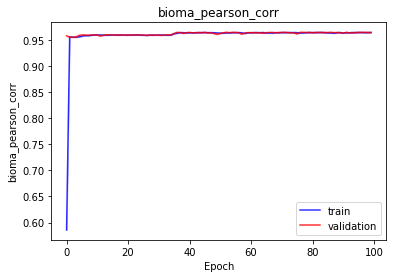

<b>bioma_jensen_shannon_divergence</b>: 0.6887 (min: 0.6887, max: 0.6887)

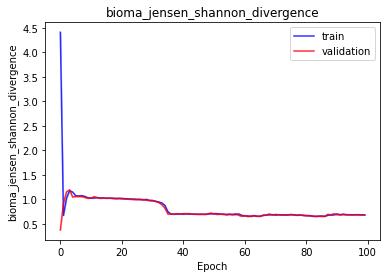

<b>domain_mse</b>: 41528140.0000 (min: 41528140.0000, max: 41528140.0000)

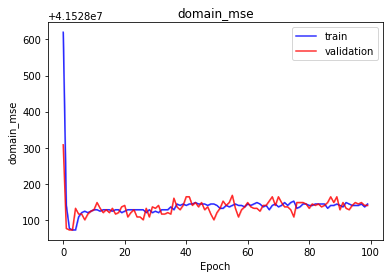

<b>domain_mae</b>: 349.4747 (min: 349.4747, max: 349.4747)

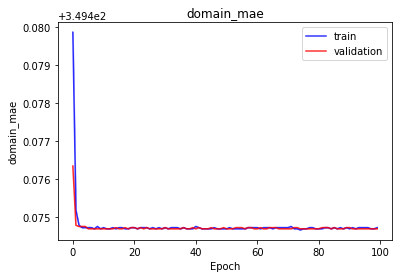

<b>domain_mape</b>: 562.1578 (min: 562.1578, max: 562.1578)

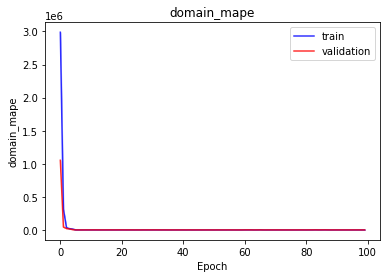

<b>domain_BrayCurtis</b>: 0.1528 (min: 0.1528, max: 0.1528)

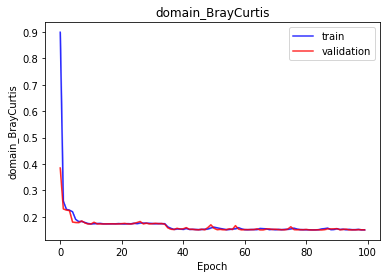

<b>domain_pearson_corr</b>: 0.9644 (min: 0.9644, max: 0.9644)

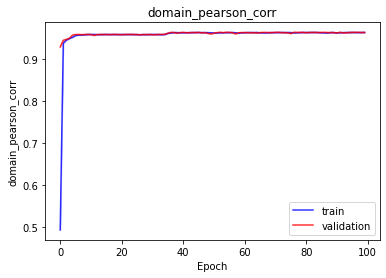

<b>domain_jensen_shannon_divergence</b>: 0.6887 (min: 0.6887, max: 0.6887)

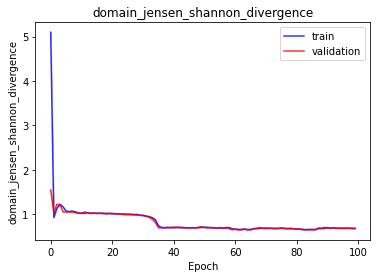

<b>latent_mae</b>: 0.0051 (min: 0.0051, max: 0.0051)

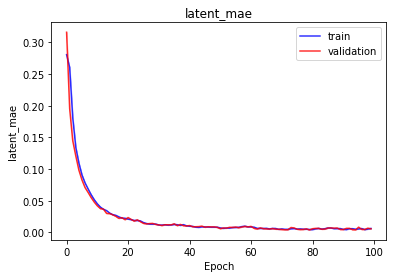

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.3106725215911865 | 0.3106725215911865 | 0.3106725215911865 |
| bioma_loss | 0.15278567373752594 | 0.15278567373752594 | 0.15278567373752594 |
| domain_loss | 0.15278606116771698 | 0.15278606116771698 | 0.15278606116771698 |
| latent_loss | 0.0051008183509111404 | 0.0051008183509111404 | 0.0051008183509111404 |
| bioma_mse | 41528140.0 | 41528140.0 | 41528140.0 |
| bioma_mae | 349.4747314453125 | 349.4747314453125 | 349.4747314453125 |
| bioma_mape | 562.0509643554688 | 562.0509643554688 | 562.0509643554688 |
| bioma_BrayCurtis | 0.15278567373752594 | 0.15278567373752594 | 0.15278567373752594 |
| bioma_pearson_corr | 0.9643625617027283 | 0.9643625617027283 | 0.9643625617027283 |
| bioma_jensen_shannon_divergence | 0.6887081265449524 | 0.6887081265449524 | 0.6887081265449524 |
| domain_mse | 41528140.0 | 41528140.0 | 41528140.0 |
| domain_mae | 349.4747314453125 | 349.4747314453125 | 349.4747314453125 |
| domain_mape | 562.1578369140625 | 562.1578369140625 | 562.1578369140625 |
| domain_BrayCurtis | 0.15278606116771698 | 0.15278606116771698 | 0.15278606116771698 |
| domain_pearson_corr | 0.9643622636795044 | 0.9643622636795044 | 0.9643622636795044 |
| domain_jensen_shannon_divergence | 0.6886902451515198 | 0.6886902451515198 | 0.6886902451515198 |
| latent_mae | 0.0051008183509111404 | 0.0051008183509111404 | 0.0051008183509111404 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.1629989594221115 | 0.1629989594221115 | 0.1629989594221115 |
| pearson_corr | 0.9622133374214172 | 0.9622133374214172 | 0.9622133374214172 |
| jensen_shannon_divergence | 0.859302818775177 | 0.859302818775177 | 0.859302818775177 |


In [47]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Family

In [48]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_familia/otus_familia_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_familia/metadatos_nutrientes_familia.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>98</b></p>

<b>loss</b>: 0.3851 (min: 0.3851, max: 0.3851)

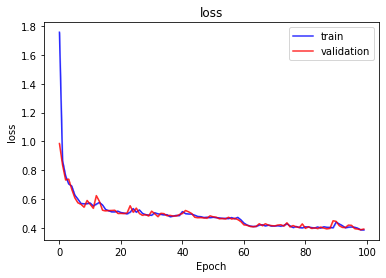

<b>bioma_loss</b>: 0.0935 (min: 0.0935, max: 0.0935)

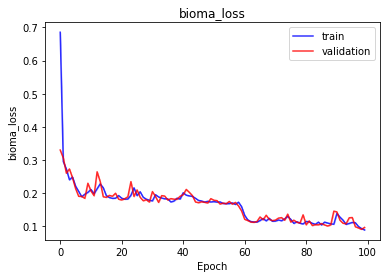

<b>domain_loss</b>: 0.2674 (min: 0.2674, max: 0.2674)

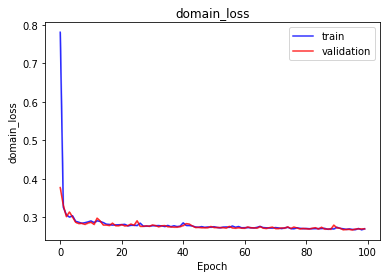

<b>latent_loss</b>: 0.0241 (min: 0.0241, max: 0.0241)

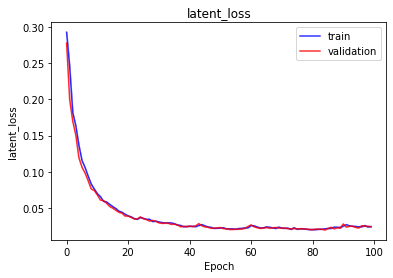

<b>bioma_mse</b>: 474643.4375 (min: 474643.4375, max: 474643.4375)

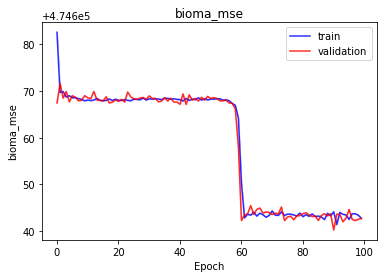

<b>bioma_mae</b>: 41.0594 (min: 41.0594, max: 41.0594)

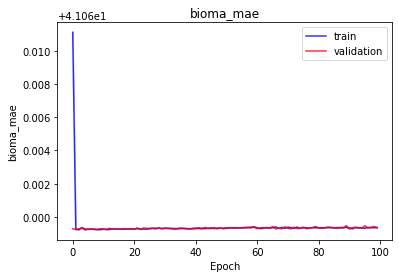

<b>bioma_mape</b>: 153563.2500 (min: 153563.2500, max: 153563.2500)

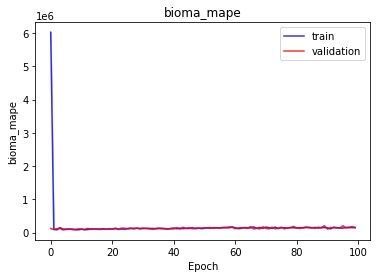

<b>bioma_BrayCurtis</b>: 0.0935 (min: 0.0935, max: 0.0935)

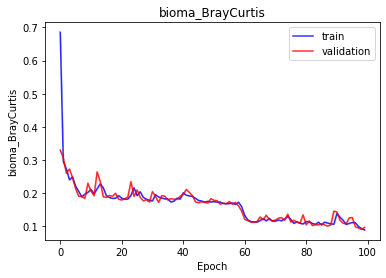

<b>bioma_pearson_corr</b>: 0.9765 (min: 0.9765, max: 0.9765)

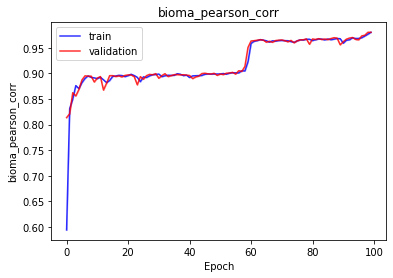

<b>bioma_jensen_shannon_divergence</b>: 0.1864 (min: 0.1864, max: 0.1864)

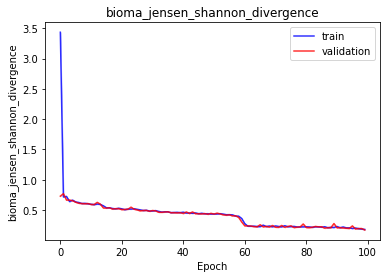

<b>domain_mse</b>: 474670.2500 (min: 474670.2500, max: 474670.2500)

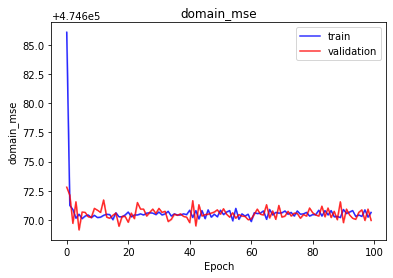

<b>domain_mae</b>: 41.0594 (min: 41.0594, max: 41.0594)

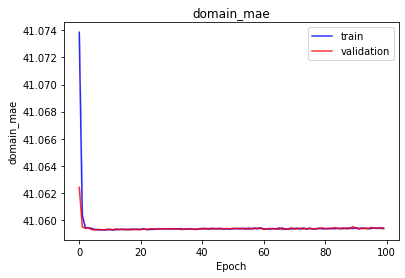

<b>domain_mape</b>: 169817.9219 (min: 169817.9219, max: 169817.9219)

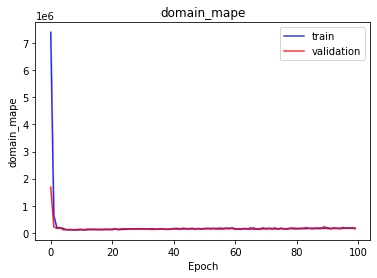

<b>domain_BrayCurtis</b>: 0.2674 (min: 0.2674, max: 0.2674)

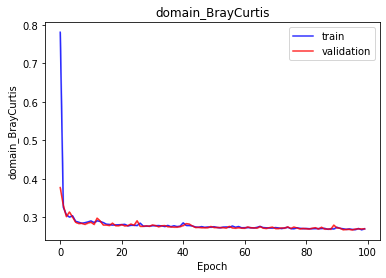

<b>domain_pearson_corr</b>: 0.8432 (min: 0.8432, max: 0.8432)

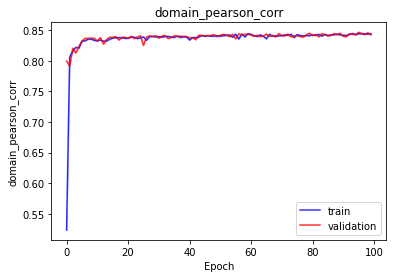

<b>domain_jensen_shannon_divergence</b>: 0.5558 (min: 0.5558, max: 0.5558)

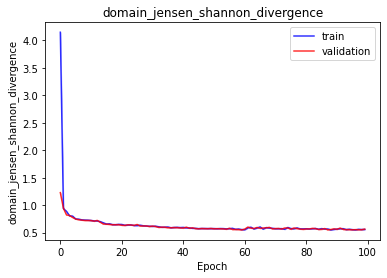

<b>latent_mae</b>: 0.0241 (min: 0.0241, max: 0.0241)

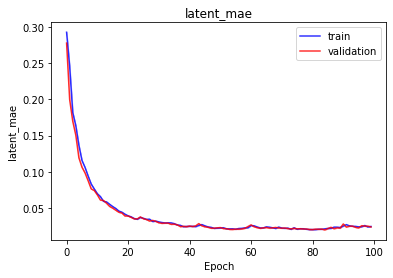

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.38508304953575134 | 0.38508304953575134 | 0.38508304953575134 |
| bioma_loss | 0.09353256970643997 | 0.09353256970643997 | 0.09353256970643997 |
| domain_loss | 0.26742830872535706 | 0.26742830872535706 | 0.26742830872535706 |
| latent_loss | 0.024122202768921852 | 0.024122202768921852 | 0.024122202768921852 |
| bioma_mse | 474643.4375 | 474643.4375 | 474643.4375 |
| bioma_mae | 41.05936050415039 | 41.05936050415039 | 41.05936050415039 |
| bioma_mape | 153563.25 | 153563.25 | 153563.25 |
| bioma_BrayCurtis | 0.09353256970643997 | 0.09353256970643997 | 0.09353256970643997 |
| bioma_pearson_corr | 0.9764604568481445 | 0.9764604568481445 | 0.9764604568481445 |
| bioma_jensen_shannon_divergence | 0.18643568456172943 | 0.18643568456172943 | 0.18643568456172943 |
| domain_mse | 474670.25 | 474670.25 | 474670.25 |
| domain_mae | 41.05939483642578 | 41.05939483642578 | 41.05939483642578 |
| domain_mape | 169817.921875 | 169817.921875 | 169817.921875 |
| domain_BrayCurtis | 0.26742830872535706 | 0.26742830872535706 | 0.26742830872535706 |
| domain_pearson_corr | 0.8432331681251526 | 0.8432331681251526 | 0.8432331681251526 |
| domain_jensen_shannon_divergence | 0.5557717084884644 | 0.5557717084884644 | 0.5557717084884644 |
| latent_mae | 0.024122202768921852 | 0.024122202768921852 | 0.024122202768921852 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2221365123987198 | 0.2221365123987198 | 0.2221365123987198 |
| pearson_corr | 0.916425883769989 | 0.916425883769989 | 0.916425883769989 |
| jensen_shannon_divergence | 0.42265525460243225 | 0.42265525460243225 | 0.42265525460243225 |


In [49]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Order

In [50]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_orden/otus_orden_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_orden/metadatos_nutrientes_orden.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>93</b></p>

<b>loss</b>: 0.1686 (min: 0.1686, max: 0.1686)

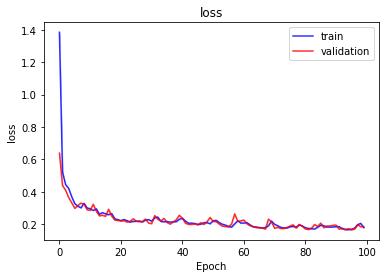

<b>bioma_loss</b>: 0.0236 (min: 0.0236, max: 0.0236)

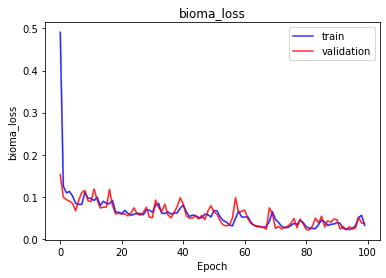

<b>domain_loss</b>: 0.1264 (min: 0.1264, max: 0.1264)

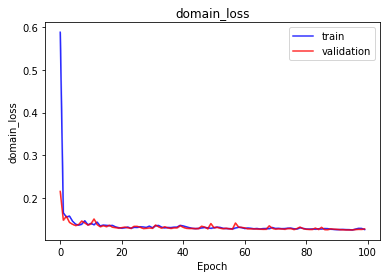

<b>latent_loss</b>: 0.0186 (min: 0.0186, max: 0.0186)

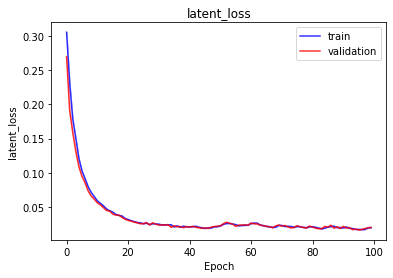

<b>bioma_mse</b>: 9804442.0000 (min: 9804442.0000, max: 9804442.0000)

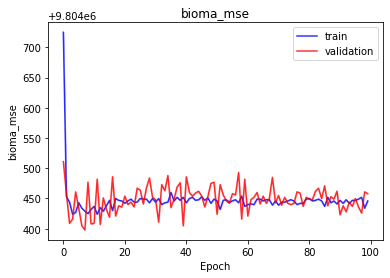

<b>bioma_mae</b>: 601.1547 (min: 601.1547, max: 601.1547)

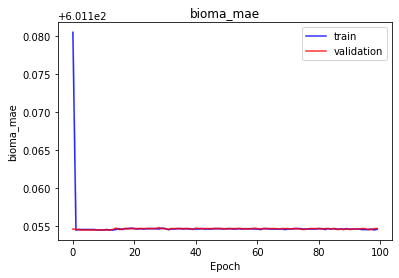

<b>bioma_mape</b>: 57647.0547 (min: 57647.0547, max: 57647.0547)

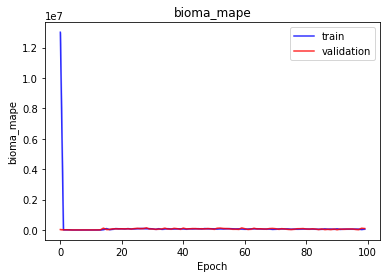

<b>bioma_BrayCurtis</b>: 0.0236 (min: 0.0236, max: 0.0236)

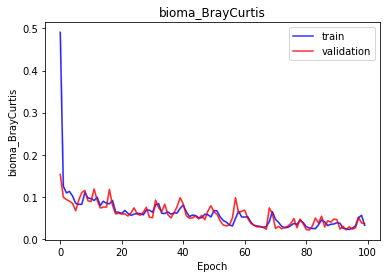

<b>bioma_pearson_corr</b>: 0.9989 (min: 0.9989, max: 0.9989)

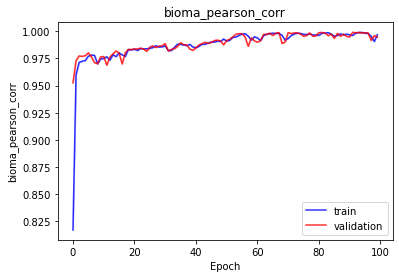

<b>bioma_jensen_shannon_divergence</b>: 0.0188 (min: 0.0188, max: 0.0188)

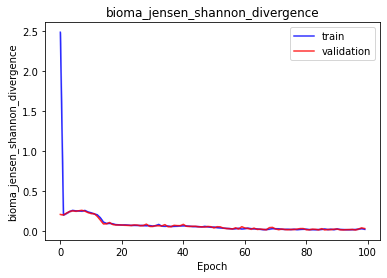

<b>domain_mse</b>: 9804469.0000 (min: 9804469.0000, max: 9804469.0000)

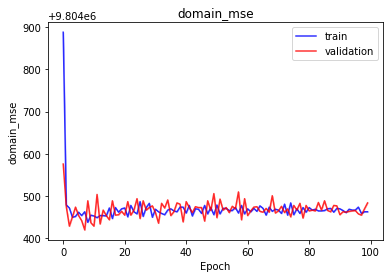

<b>domain_mae</b>: 601.1547 (min: 601.1547, max: 601.1547)

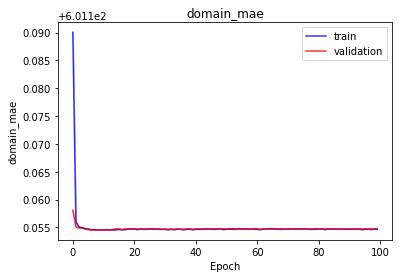

<b>domain_mape</b>: 71870.5156 (min: 71870.5156, max: 71870.5156)

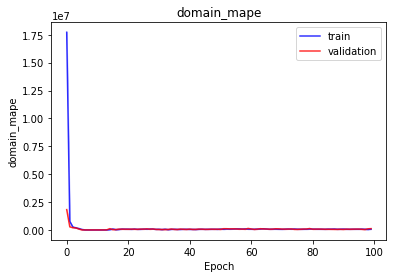

<b>domain_BrayCurtis</b>: 0.1264 (min: 0.1264, max: 0.1264)

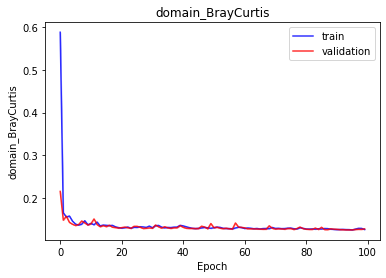

<b>domain_pearson_corr</b>: 0.9576 (min: 0.9576, max: 0.9576)

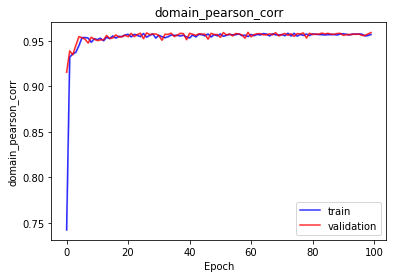

<b>domain_jensen_shannon_divergence</b>: 0.1242 (min: 0.1242, max: 0.1242)

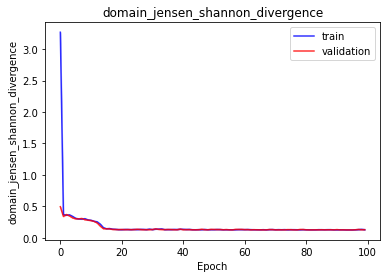

<b>latent_mae</b>: 0.0186 (min: 0.0186, max: 0.0186)

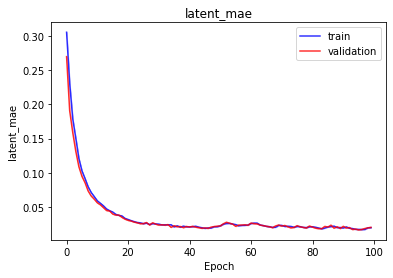

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.1686370074748993 | 0.1686370074748993 | 0.1686370074748993 |
| bioma_loss | 0.023635469377040863 | 0.023635469377040863 | 0.023635469377040863 |
| domain_loss | 0.12638434767723083 | 0.12638434767723083 | 0.12638434767723083 |
| latent_loss | 0.018617188557982445 | 0.018617188557982445 | 0.018617188557982445 |
| bioma_mse | 9804442.0 | 9804442.0 | 9804442.0 |
| bioma_mae | 601.1546630859375 | 601.1546630859375 | 601.1546630859375 |
| bioma_mape | 57647.0546875 | 57647.0546875 | 57647.0546875 |
| bioma_BrayCurtis | 0.023635469377040863 | 0.023635469377040863 | 0.023635469377040863 |
| bioma_pearson_corr | 0.9988859295845032 | 0.9988859295845032 | 0.9988859295845032 |
| bioma_jensen_shannon_divergence | 0.018842939287424088 | 0.018842939287424088 | 0.018842939287424088 |
| domain_mse | 9804469.0 | 9804469.0 | 9804469.0 |
| domain_mae | 601.1547241210938 | 601.1547241210938 | 601.1547241210938 |
| domain_mape | 71870.515625 | 71870.515625 | 71870.515625 |
| domain_BrayCurtis | 0.12638434767723083 | 0.12638434767723083 | 0.12638434767723083 |
| domain_pearson_corr | 0.9576048851013184 | 0.9576048851013184 | 0.9576048851013184 |
| domain_jensen_shannon_divergence | 0.12421518564224243 | 0.12421518564224243 | 0.12421518564224243 |
| latent_mae | 0.018617188557982445 | 0.018617188557982445 | 0.018617188557982445 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.13876385986804962 | 0.13876385986804962 | 0.13876385986804962 |
| pearson_corr | 0.9651816487312317 | 0.9651816487312317 | 0.9651816487312317 |
| jensen_shannon_divergence | 0.11836907267570496 | 0.11836907267570496 | 0.11836907267570496 |


In [51]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Class

In [52]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_clase/otus_clase_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_clase/metadatos_nutrientes_clase.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>93</b></p>

<b>loss</b>: 0.8029 (min: 0.8029, max: 0.8029)

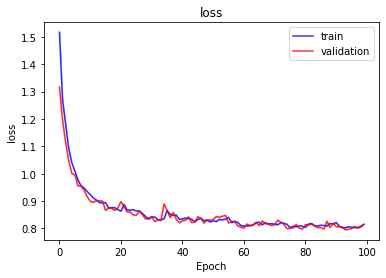

<b>bioma_loss</b>: 0.2379 (min: 0.2379, max: 0.2379)

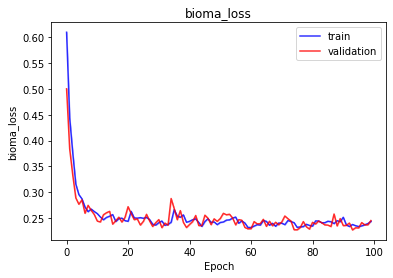

<b>domain_loss</b>: 0.5295 (min: 0.5295, max: 0.5295)

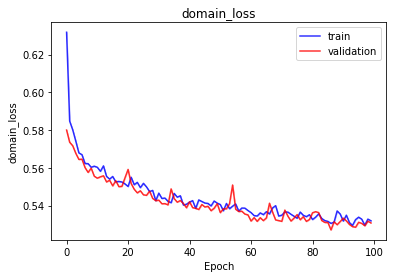

<b>latent_loss</b>: 0.0355 (min: 0.0355, max: 0.0355)

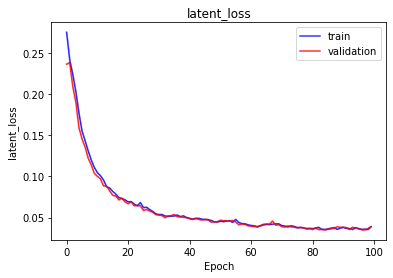

<b>bioma_mse</b>: 12.1062 (min: 12.1062, max: 12.1062)

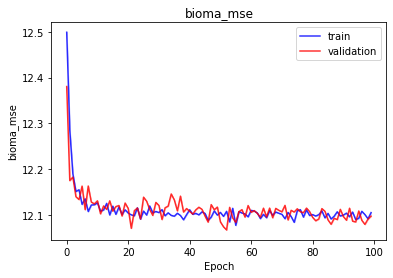

<b>bioma_mae</b>: 0.9352 (min: 0.9352, max: 0.9352)

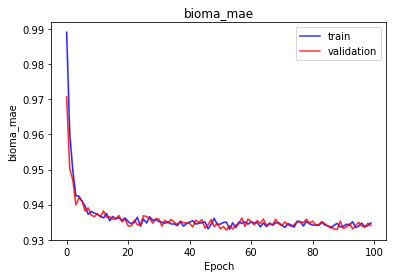

<b>bioma_mape</b>: 13441276.0000 (min: 13441276.0000, max: 13441276.0000)

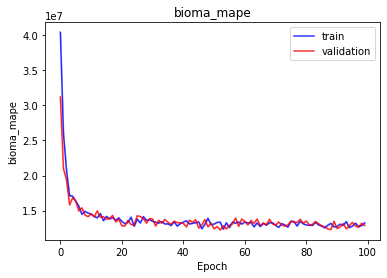

<b>bioma_BrayCurtis</b>: 0.2379 (min: 0.2379, max: 0.2379)

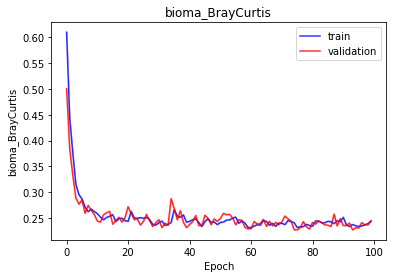

<b>bioma_pearson_corr</b>: 0.8416 (min: 0.8416, max: 0.8416)

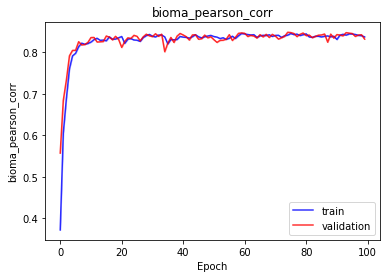

<b>bioma_jensen_shannon_divergence</b>: 1.2657 (min: 1.2657, max: 1.2657)

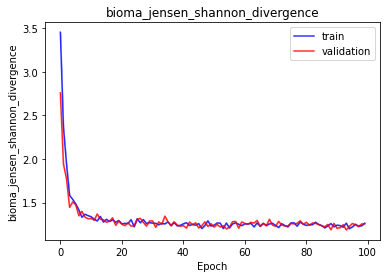

<b>domain_mse</b>: 12.4085 (min: 12.4085, max: 12.4085)

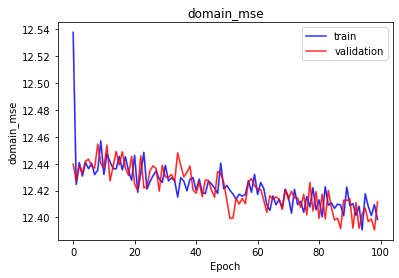

<b>domain_mae</b>: 0.9720 (min: 0.9720, max: 0.9720)

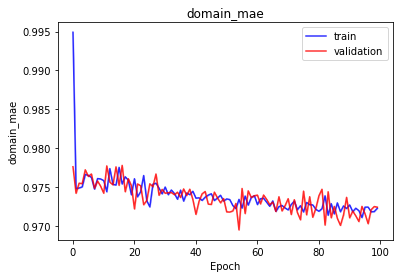

<b>domain_mape</b>: 31841766.0000 (min: 31841766.0000, max: 31841766.0000)

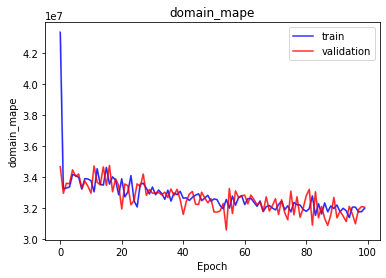

<b>domain_BrayCurtis</b>: 0.5295 (min: 0.5295, max: 0.5295)

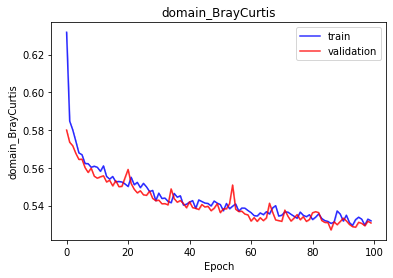

<b>domain_pearson_corr</b>: 0.4928 (min: 0.4928, max: 0.4928)

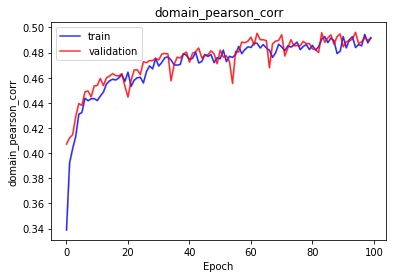

<b>domain_jensen_shannon_divergence</b>: 3.0668 (min: 3.0668, max: 3.0668)

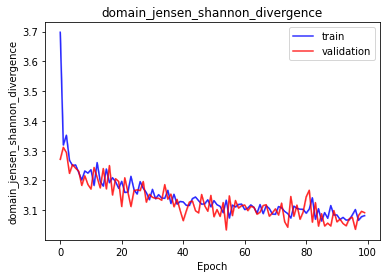

<b>latent_mae</b>: 0.0355 (min: 0.0355, max: 0.0355)

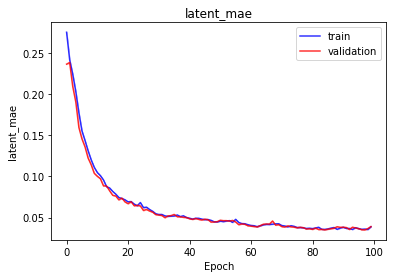

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.8028753399848938 | 0.8028753399848938 | 0.8028753399848938 |
| bioma_loss | 0.23788891732692719 | 0.23788891732692719 | 0.23788891732692719 |
| domain_loss | 0.529491662979126 | 0.529491662979126 | 0.529491662979126 |
| latent_loss | 0.035494714975357056 | 0.035494714975357056 | 0.035494714975357056 |
| bioma_mse | 12.106185913085938 | 12.106185913085938 | 12.106185913085938 |
| bioma_mae | 0.9351665377616882 | 0.9351665377616882 | 0.9351665377616882 |
| bioma_mape | 13441276.0 | 13441276.0 | 13441276.0 |
| bioma_BrayCurtis | 0.23788891732692719 | 0.23788891732692719 | 0.23788891732692719 |
| bioma_pearson_corr | 0.8415527939796448 | 0.8415527939796448 | 0.8415527939796448 |
| bioma_jensen_shannon_divergence | 1.2656646966934204 | 1.2656646966934204 | 1.2656646966934204 |
| domain_mse | 12.408480644226074 | 12.408480644226074 | 12.408480644226074 |
| domain_mae | 0.9719675183296204 | 0.9719675183296204 | 0.9719675183296204 |
| domain_mape | 31841766.0 | 31841766.0 | 31841766.0 |
| domain_BrayCurtis | 0.529491662979126 | 0.529491662979126 | 0.529491662979126 |
| domain_pearson_corr | 0.4927513897418976 | 0.4927513897418976 | 0.4927513897418976 |
| domain_jensen_shannon_divergence | 3.066826343536377 | 3.066826343536377 | 3.066826343536377 |
| latent_mae | 0.035494714975357056 | 0.035494714975357056 | 0.035494714975357056 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.5956767201423645 | 0.5956767201423645 | 0.5956767201423645 |
| pearson_corr | 0.4323582053184509 | 0.4323582053184509 | 0.4323582053184509 |
| jensen_shannon_divergence | 3.551929473876953 | 3.551929473876953 | 3.551929473876953 |


In [53]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Phylum

In [54]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_filo/otus_filo_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_filo/metadatos_nutrientes_filo.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 128 -> 15 -> 128 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 8 -> 15 -> 128 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>96</b></p>

<b>loss</b>: 0.2040 (min: 0.2040, max: 0.2040)

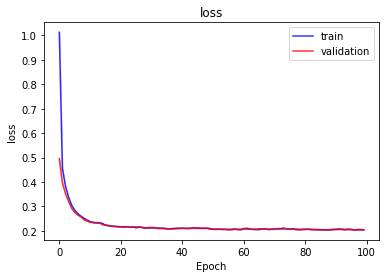

<b>bioma_loss</b>: 0.0995 (min: 0.0995, max: 0.0995)

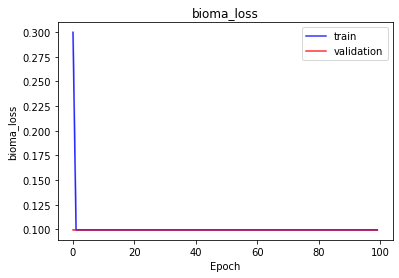

<b>domain_loss</b>: 0.0995 (min: 0.0995, max: 0.0995)

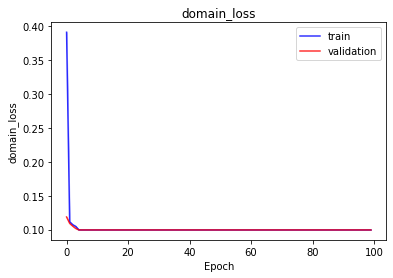

<b>latent_loss</b>: 0.0049 (min: 0.0049, max: 0.0049)

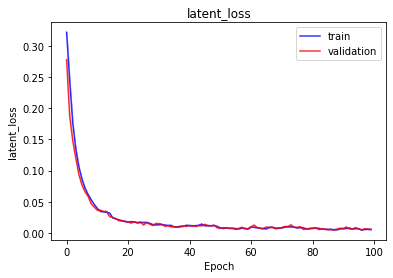

<b>bioma_mse</b>: 134845.0469 (min: 134845.0469, max: 134845.0469)

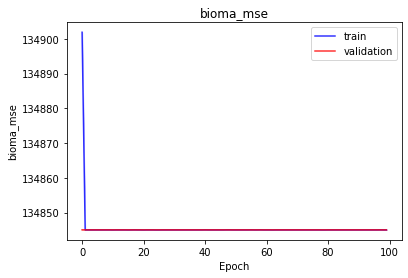

<b>bioma_mae</b>: 118.1727 (min: 118.1727, max: 118.1727)

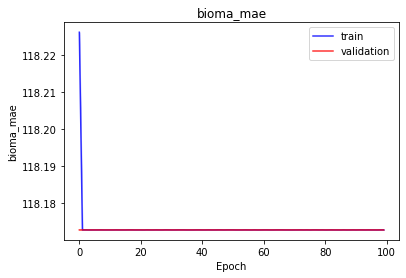

<b>bioma_mape</b>: 356179.4062 (min: 356179.4062, max: 356179.4062)

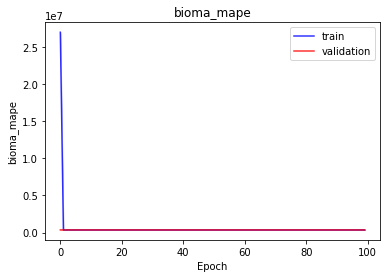

<b>bioma_BrayCurtis</b>: 0.0995 (min: 0.0995, max: 0.0995)

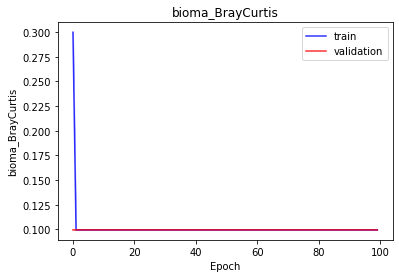

<b>bioma_pearson_corr</b>: 0.9778 (min: 0.9778, max: 0.9778)

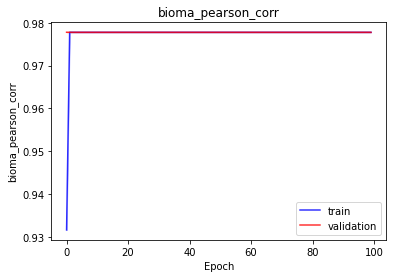

<b>bioma_jensen_shannon_divergence</b>: 0.9913 (min: 0.9913, max: 0.9913)

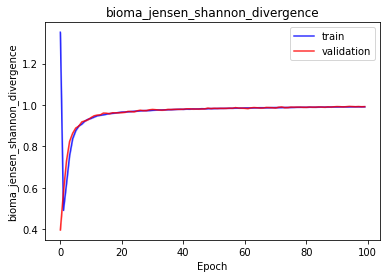

<b>domain_mse</b>: 134845.0469 (min: 134845.0469, max: 134845.0469)

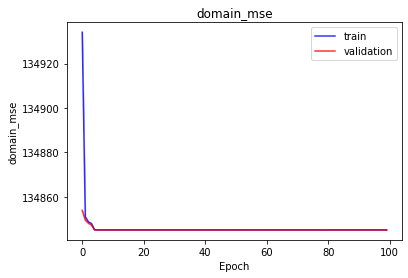

<b>domain_mae</b>: 118.1727 (min: 118.1727, max: 118.1727)

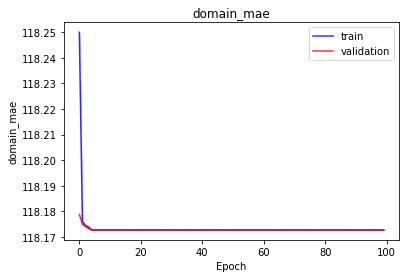

<b>domain_mape</b>: 356179.4062 (min: 356179.4062, max: 356179.4062)

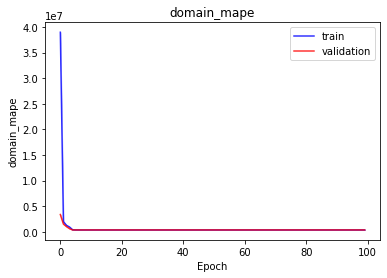

<b>domain_BrayCurtis</b>: 0.0995 (min: 0.0995, max: 0.0995)

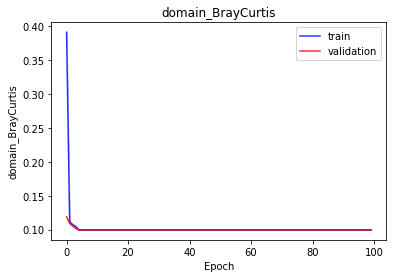

<b>domain_pearson_corr</b>: 0.9778 (min: 0.9778, max: 0.9778)

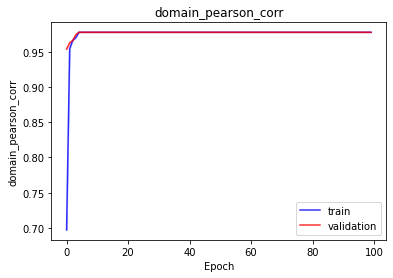

<b>domain_jensen_shannon_divergence</b>: 0.9912 (min: 0.9912, max: 0.9912)

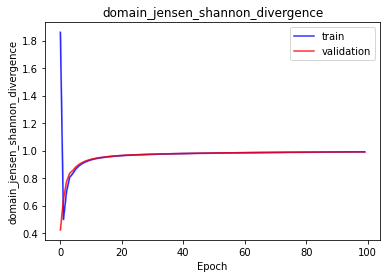

<b>latent_mae</b>: 0.0049 (min: 0.0049, max: 0.0049)

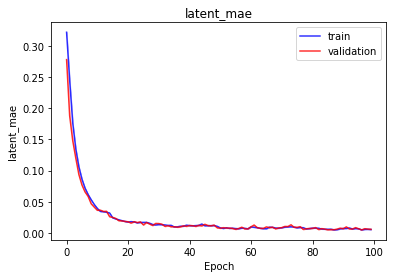

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.20396366715431213 | 0.20396366715431213 | 0.20396366715431213 |
| bioma_loss | 0.09951116144657135 | 0.09951116144657135 | 0.09951116144657135 |
| domain_loss | 0.09951116144657135 | 0.09951116144657135 | 0.09951116144657135 |
| latent_loss | 0.004941333085298538 | 0.004941333085298538 | 0.004941333085298538 |
| bioma_mse | 134845.046875 | 134845.046875 | 134845.046875 |
| bioma_mae | 118.17271423339844 | 118.17271423339844 | 118.17271423339844 |
| bioma_mape | 356179.40625 | 356179.40625 | 356179.40625 |
| bioma_BrayCurtis | 0.09951116144657135 | 0.09951116144657135 | 0.09951116144657135 |
| bioma_pearson_corr | 0.9777647256851196 | 0.9777647256851196 | 0.9777647256851196 |
| bioma_jensen_shannon_divergence | 0.9913478493690491 | 0.9913478493690491 | 0.9913478493690491 |
| domain_mse | 134845.046875 | 134845.046875 | 134845.046875 |
| domain_mae | 118.17271423339844 | 118.17271423339844 | 118.17271423339844 |
| domain_mape | 356179.40625 | 356179.40625 | 356179.40625 |
| domain_BrayCurtis | 0.09951116144657135 | 0.09951116144657135 | 0.09951116144657135 |
| domain_pearson_corr | 0.9777647256851196 | 0.9777647256851196 | 0.9777647256851196 |
| domain_jensen_shannon_divergence | 0.9911535978317261 | 0.9911535978317261 | 0.9911535978317261 |
| latent_mae | 0.004941333085298538 | 0.004941333085298538 | 0.004941333085298538 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.11989408731460571 | 0.11989408731460571 | 0.11989408731460571 |
| pearson_corr | 0.9541983008384705 | 0.9541983008384705 | 0.9541983008384705 |
| jensen_shannon_divergence | 1.2402141094207764 | 1.2402141094207764 | 1.2402141094207764 |


In [55]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256,128],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Kingdom

In [ ]:
????????????????Lo hago?

--------------------------
# 22 variables Latent OTU

### Genus

In [56]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_genero/otus_genero_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_genero/metadatos_nutrientes_genero.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.4451 (min: 0.4451, max: 0.4451)

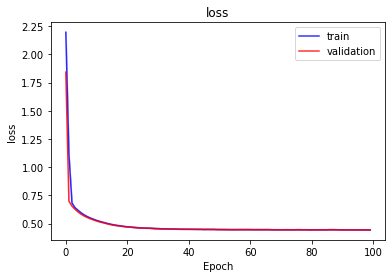

<b>bioma_loss</b>: 0.2213 (min: 0.2213, max: 0.2213)

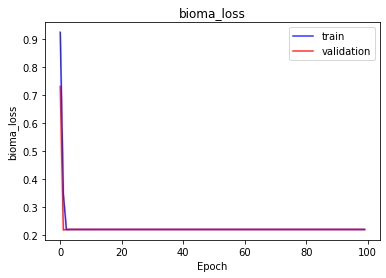

<b>domain_loss</b>: 0.2213 (min: 0.2213, max: 0.2213)

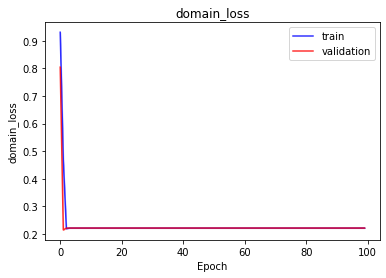

<b>latent_loss</b>: 0.0025 (min: 0.0025, max: 0.0025)

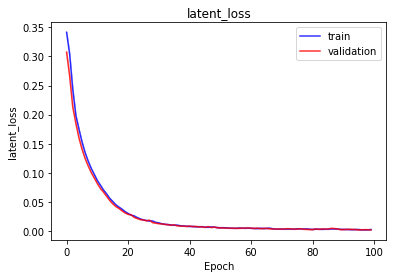

<b>bioma_mse</b>: 41528060.0000 (min: 41528060.0000, max: 41528060.0000)

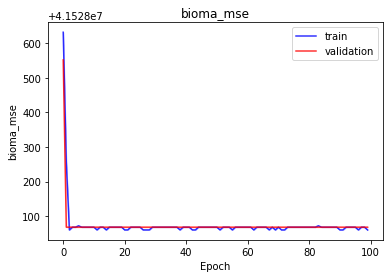

<b>bioma_mae</b>: 349.4747 (min: 349.4747, max: 349.4747)

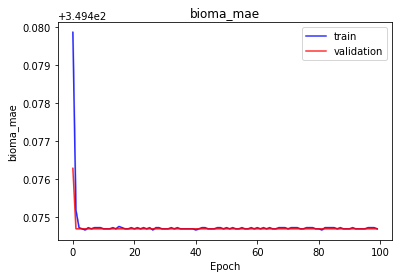

<b>bioma_mape</b>: 14.7841 (min: 14.7841, max: 14.7841)

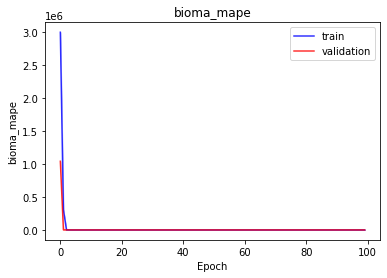

<b>bioma_BrayCurtis</b>: 0.2213 (min: 0.2213, max: 0.2213)

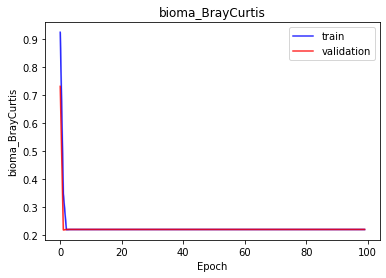

<b>bioma_pearson_corr</b>: 0.9556 (min: 0.9556, max: 0.9556)

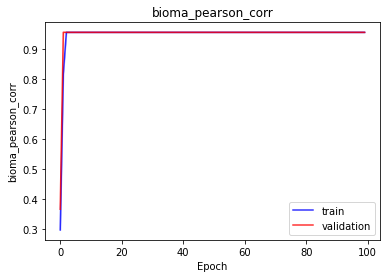

<b>bioma_jensen_shannon_divergence</b>: 1.9092 (min: 1.9092, max: 1.9092)

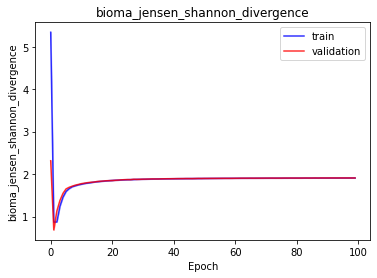

<b>domain_mse</b>: 41528060.0000 (min: 41528060.0000, max: 41528060.0000)

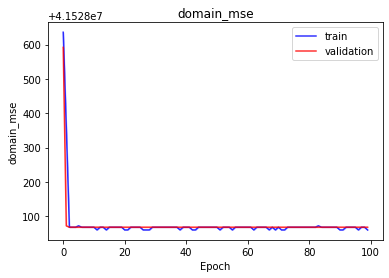

<b>domain_mae</b>: 349.4747 (min: 349.4747, max: 349.4747)

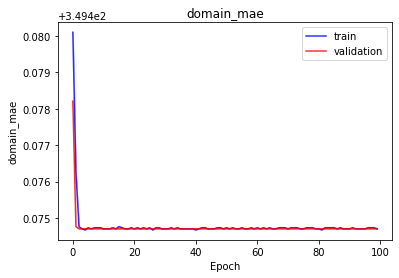

<b>domain_mape</b>: 14.7841 (min: 14.7841, max: 14.7841)

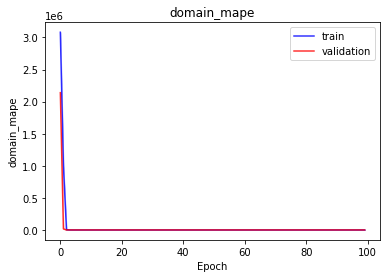

<b>domain_BrayCurtis</b>: 0.2213 (min: 0.2213, max: 0.2213)

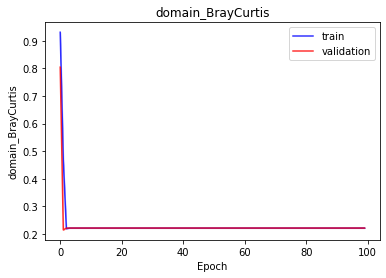

<b>domain_pearson_corr</b>: 0.9556 (min: 0.9556, max: 0.9556)

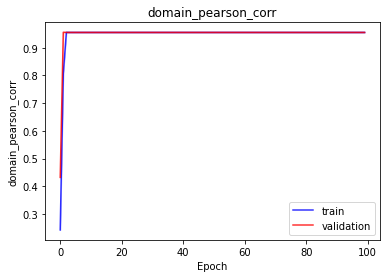

<b>domain_jensen_shannon_divergence</b>: 1.9090 (min: 1.9090, max: 1.9090)

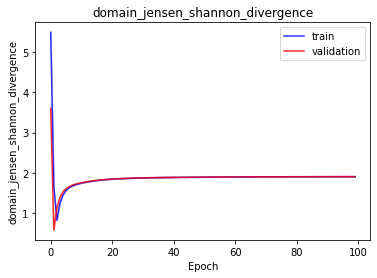

<b>latent_mae</b>: 0.0025 (min: 0.0025, max: 0.0025)

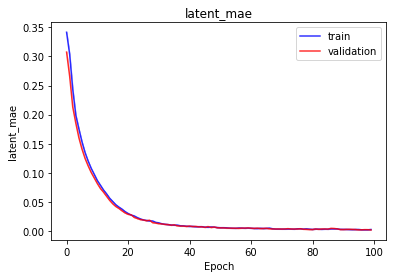

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.4450802505016327 | 0.4450802505016327 | 0.4450802505016327 |
| bioma_loss | 0.2212664932012558 | 0.2212664932012558 | 0.2212664932012558 |
| domain_loss | 0.2212664932012558 | 0.2212664932012558 | 0.2212664932012558 |
| latent_loss | 0.0025472636334598064 | 0.0025472636334598064 | 0.0025472636334598064 |
| bioma_mse | 41528060.0 | 41528060.0 | 41528060.0 |
| bioma_mae | 349.4747009277344 | 349.4747009277344 | 349.4747009277344 |
| bioma_mape | 14.784062385559082 | 14.784062385559082 | 14.784062385559082 |
| bioma_BrayCurtis | 0.2212664932012558 | 0.2212664932012558 | 0.2212664932012558 |
| bioma_pearson_corr | 0.9555657505989075 | 0.9555657505989075 | 0.9555657505989075 |
| bioma_jensen_shannon_divergence | 1.9091997146606445 | 1.9091997146606445 | 1.9091997146606445 |
| domain_mse | 41528060.0 | 41528060.0 | 41528060.0 |
| domain_mae | 349.4747009277344 | 349.4747009277344 | 349.4747009277344 |
| domain_mape | 14.784064292907715 | 14.784064292907715 | 14.784064292907715 |
| domain_BrayCurtis | 0.2212664932012558 | 0.2212664932012558 | 0.2212664932012558 |
| domain_pearson_corr | 0.9555657505989075 | 0.9555657505989075 | 0.9555657505989075 |
| domain_jensen_shannon_divergence | 1.9090189933776855 | 1.9090189933776855 | 1.9090189933776855 |
| latent_mae | 0.0025472636334598064 | 0.0025472636334598064 | 0.0025472636334598064 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.23275898396968842 | 0.23275898396968842 | 0.23275898396968842 |
| pearson_corr | 0.9532116055488586 | 0.9532116055488586 | 0.9532116055488586 |
| jensen_shannon_divergence | 2.0409581661224365 | 2.0409581661224365 | 2.0409581661224365 |


In [57]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Family

In [58]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_familia/otus_familia_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_familia/metadatos_nutrientes_familia.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>99</b></p>

<b>loss</b>: 0.3956 (min: 0.3956, max: 0.3956)

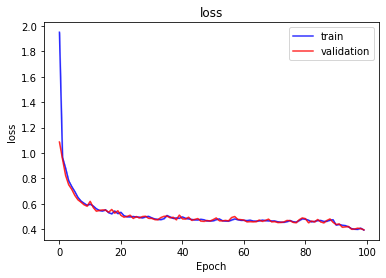

<b>bioma_loss</b>: 0.0998 (min: 0.0998, max: 0.0998)

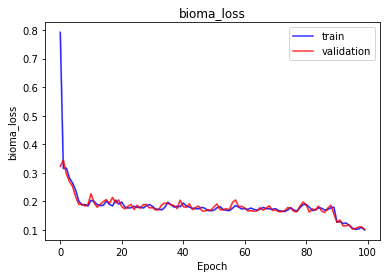

<b>domain_loss</b>: 0.2688 (min: 0.2688, max: 0.2688)

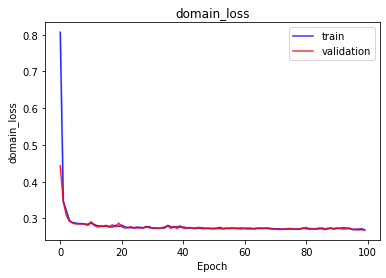

<b>latent_loss</b>: 0.0271 (min: 0.0271, max: 0.0271)

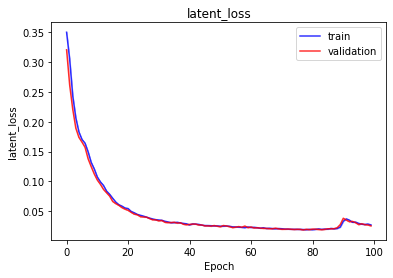

<b>bioma_mse</b>: 474643.5938 (min: 474643.5938, max: 474643.5938)

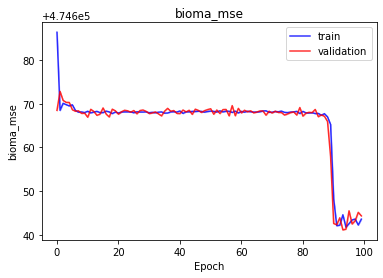

<b>bioma_mae</b>: 41.0593 (min: 41.0593, max: 41.0593)

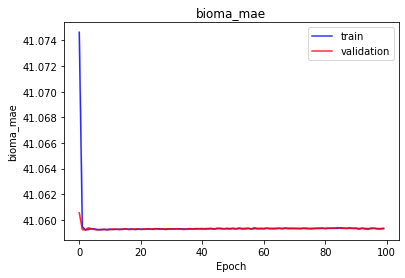

<b>bioma_mape</b>: 137582.4219 (min: 137582.4219, max: 137582.4219)

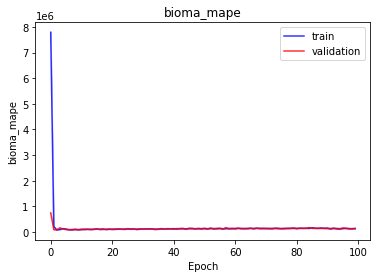

<b>bioma_BrayCurtis</b>: 0.0998 (min: 0.0998, max: 0.0998)

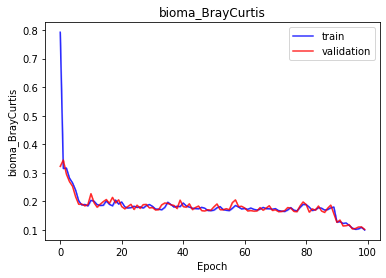

<b>bioma_pearson_corr</b>: 0.9708 (min: 0.9708, max: 0.9708)

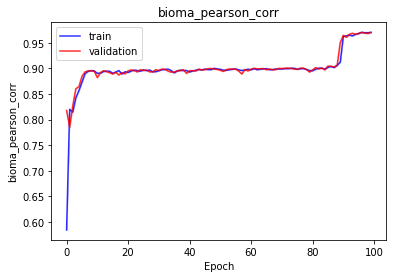

<b>bioma_jensen_shannon_divergence</b>: 0.1957 (min: 0.1957, max: 0.1957)

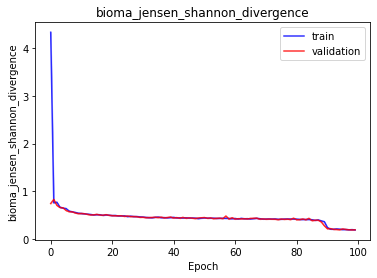

<b>domain_mse</b>: 474670.5000 (min: 474670.5000, max: 474670.5000)

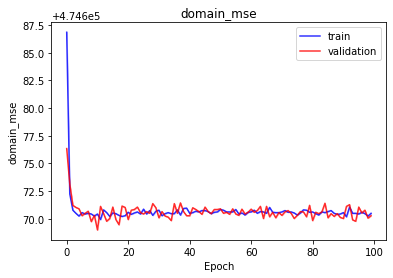

<b>domain_mae</b>: 41.0594 (min: 41.0594, max: 41.0594)

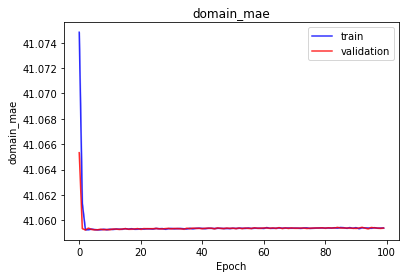

<b>domain_mape</b>: 174088.0312 (min: 174088.0312, max: 174088.0312)

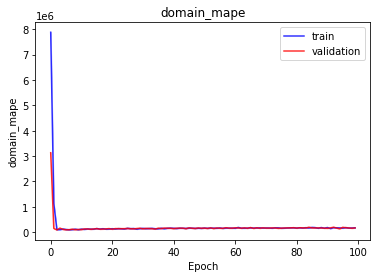

<b>domain_BrayCurtis</b>: 0.2688 (min: 0.2688, max: 0.2688)

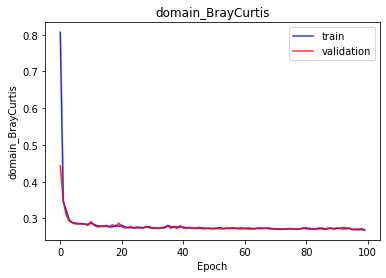

<b>domain_pearson_corr</b>: 0.8439 (min: 0.8439, max: 0.8439)

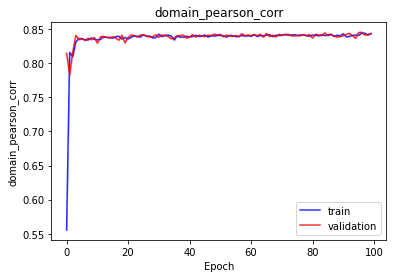

<b>domain_jensen_shannon_divergence</b>: 0.5432 (min: 0.5432, max: 0.5432)

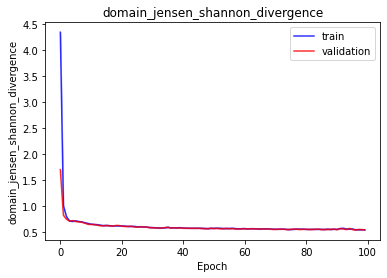

<b>latent_mae</b>: 0.0271 (min: 0.0271, max: 0.0271)

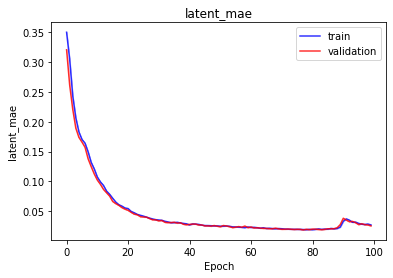

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.39563703536987305 | 0.39563703536987305 | 0.39563703536987305 |
| bioma_loss | 0.09975066781044006 | 0.09975066781044006 | 0.09975066781044006 |
| domain_loss | 0.2687929570674896 | 0.2687929570674896 | 0.2687929570674896 |
| latent_loss | 0.027093371376395226 | 0.027093371376395226 | 0.027093371376395226 |
| bioma_mse | 474643.59375 | 474643.59375 | 474643.59375 |
| bioma_mae | 41.05933380126953 | 41.05933380126953 | 41.05933380126953 |
| bioma_mape | 137582.421875 | 137582.421875 | 137582.421875 |
| bioma_BrayCurtis | 0.09975066781044006 | 0.09975066781044006 | 0.09975066781044006 |
| bioma_pearson_corr | 0.9707790017127991 | 0.9707790017127991 | 0.9707790017127991 |
| bioma_jensen_shannon_divergence | 0.19565865397453308 | 0.19565865397453308 | 0.19565865397453308 |
| domain_mse | 474670.5 | 474670.5 | 474670.5 |
| domain_mae | 41.05939865112305 | 41.05939865112305 | 41.05939865112305 |
| domain_mape | 174088.03125 | 174088.03125 | 174088.03125 |
| domain_BrayCurtis | 0.2687929570674896 | 0.2687929570674896 | 0.2687929570674896 |
| domain_pearson_corr | 0.8439416885375977 | 0.8439416885375977 | 0.8439416885375977 |
| domain_jensen_shannon_divergence | 0.5431613326072693 | 0.5431613326072693 | 0.5431613326072693 |
| latent_mae | 0.027093371376395226 | 0.027093371376395226 | 0.027093371376395226 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.21124473214149475 | 0.21124473214149475 | 0.21124473214149475 |
| pearson_corr | 0.9198793172836304 | 0.9198793172836304 | 0.9198793172836304 |
| jensen_shannon_divergence | 0.3801448941230774 | 0.3801448941230774 | 0.3801448941230774 |


In [59]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Order

In [60]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_orden/otus_orden_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_orden/metadatos_nutrientes_orden.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>97</b></p>

<b>loss</b>: 0.1685 (min: 0.1685, max: 0.1685)

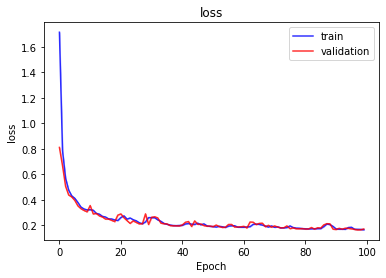

<b>bioma_loss</b>: 0.0200 (min: 0.0200, max: 0.0200)

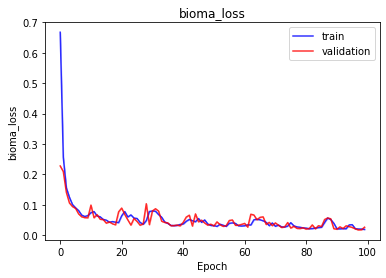

<b>domain_loss</b>: 0.1270 (min: 0.1270, max: 0.1270)

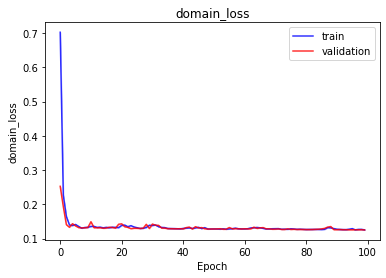

<b>latent_loss</b>: 0.0215 (min: 0.0215, max: 0.0215)

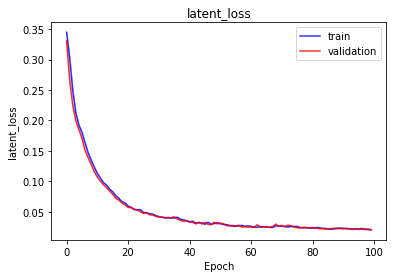

<b>bioma_mse</b>: 9804446.0000 (min: 9804446.0000, max: 9804446.0000)

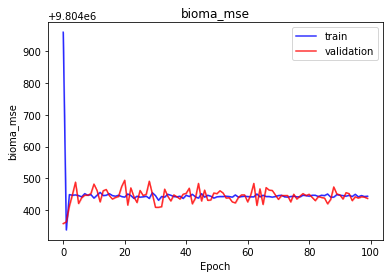

<b>bioma_mae</b>: 601.1547 (min: 601.1547, max: 601.1547)

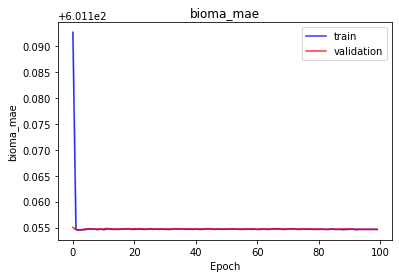

<b>bioma_mape</b>: 55210.9414 (min: 55210.9414, max: 55210.9414)

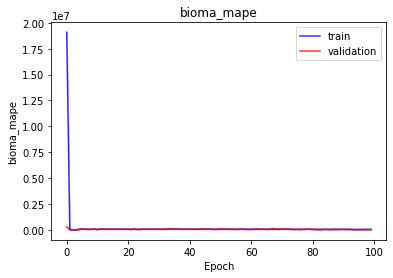

<b>bioma_BrayCurtis</b>: 0.0200 (min: 0.0200, max: 0.0200)

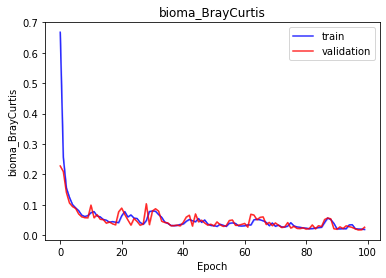

<b>bioma_pearson_corr</b>: 0.9992 (min: 0.9992, max: 0.9992)

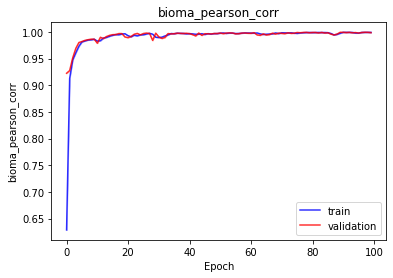

<b>bioma_jensen_shannon_divergence</b>: 0.0183 (min: 0.0183, max: 0.0183)

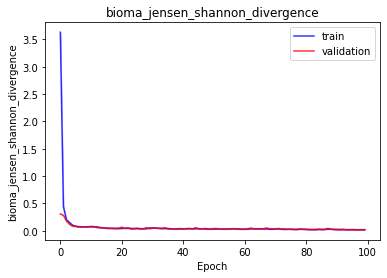

<b>domain_mse</b>: 9804460.0000 (min: 9804460.0000, max: 9804460.0000)

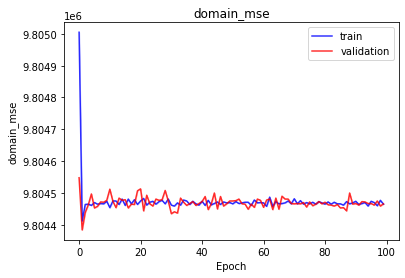

<b>domain_mae</b>: 601.1547 (min: 601.1547, max: 601.1547)

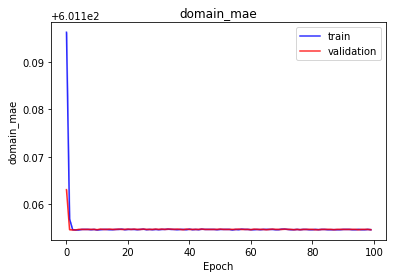

<b>domain_mape</b>: 60796.7305 (min: 60796.7305, max: 60796.7305)

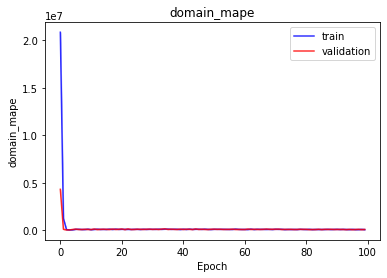

<b>domain_BrayCurtis</b>: 0.1270 (min: 0.1270, max: 0.1270)

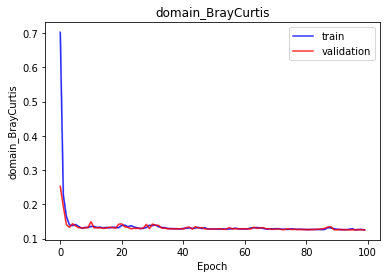

<b>domain_pearson_corr</b>: 0.9563 (min: 0.9563, max: 0.9563)

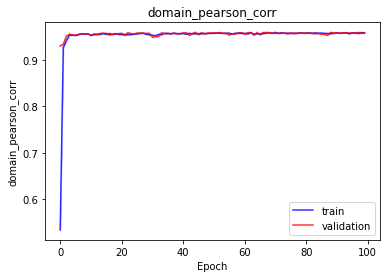

<b>domain_jensen_shannon_divergence</b>: 0.1222 (min: 0.1222, max: 0.1222)

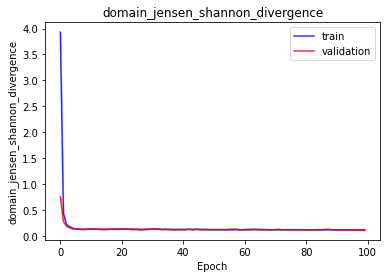

<b>latent_mae</b>: 0.0215 (min: 0.0215, max: 0.0215)

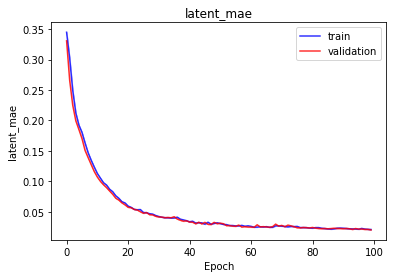

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.16846229135990143 | 0.16846229135990143 | 0.16846229135990143 |
| bioma_loss | 0.020030828192830086 | 0.020030828192830086 | 0.020030828192830086 |
| domain_loss | 0.12697093188762665 | 0.12697093188762665 | 0.12697093188762665 |
| latent_loss | 0.021460535004734993 | 0.021460535004734993 | 0.021460535004734993 |
| bioma_mse | 9804446.0 | 9804446.0 | 9804446.0 |
| bioma_mae | 601.1546630859375 | 601.1546630859375 | 601.1546630859375 |
| bioma_mape | 55210.94140625 | 55210.94140625 | 55210.94140625 |
| bioma_BrayCurtis | 0.020030828192830086 | 0.020030828192830086 | 0.020030828192830086 |
| bioma_pearson_corr | 0.9991839528083801 | 0.9991839528083801 | 0.9991839528083801 |
| bioma_jensen_shannon_divergence | 0.0182990450412035 | 0.0182990450412035 | 0.0182990450412035 |
| domain_mse | 9804460.0 | 9804460.0 | 9804460.0 |
| domain_mae | 601.1546630859375 | 601.1546630859375 | 601.1546630859375 |
| domain_mape | 60796.73046875 | 60796.73046875 | 60796.73046875 |
| domain_BrayCurtis | 0.12697093188762665 | 0.12697093188762665 | 0.12697093188762665 |
| domain_pearson_corr | 0.9563419818878174 | 0.9563419818878174 | 0.9563419818878174 |
| domain_jensen_shannon_divergence | 0.12223966419696808 | 0.12223966419696808 | 0.12223966419696808 |
| latent_mae | 0.021460535004734993 | 0.021460535004734993 | 0.021460535004734993 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.13964419066905975 | 0.13964419066905975 | 0.13964419066905975 |
| pearson_corr | 0.9631302356719971 | 0.9631302356719971 | 0.9631302356719971 |
| jensen_shannon_divergence | 0.11619902402162552 | 0.11619902402162552 | 0.11619902402162552 |


In [61]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Class

In [62]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_clase/otus_clase_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_clase/metadatos_nutrientes_clase.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>98</b></p>

<b>loss</b>: 0.8115 (min: 0.8115, max: 0.8115)

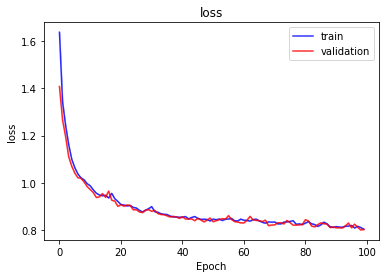

<b>bioma_loss</b>: 0.2353 (min: 0.2353, max: 0.2353)

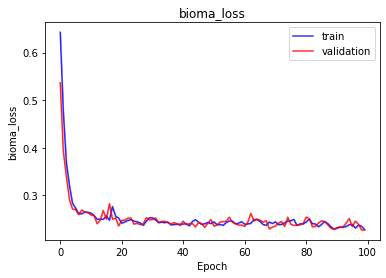

<b>domain_loss</b>: 0.5317 (min: 0.5317, max: 0.5317)

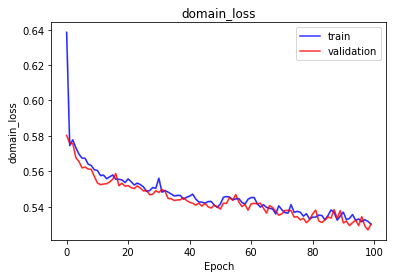

<b>latent_loss</b>: 0.0445 (min: 0.0445, max: 0.0445)

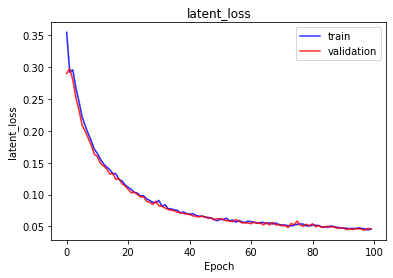

<b>bioma_mse</b>: 12.1157 (min: 12.1157, max: 12.1157)

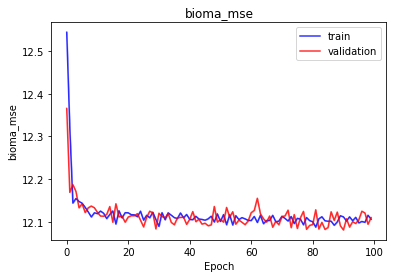

<b>bioma_mae</b>: 0.9349 (min: 0.9349, max: 0.9349)

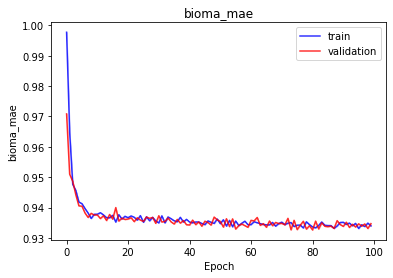

<b>bioma_mape</b>: 13314804.0000 (min: 13314804.0000, max: 13314804.0000)

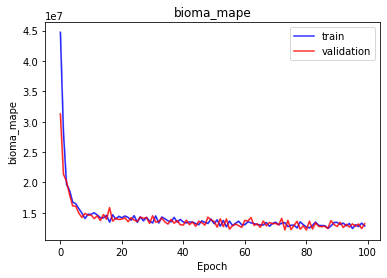

<b>bioma_BrayCurtis</b>: 0.2353 (min: 0.2353, max: 0.2353)

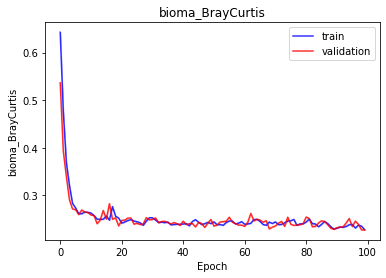

<b>bioma_pearson_corr</b>: 0.8423 (min: 0.8423, max: 0.8423)

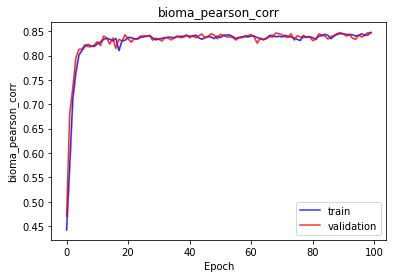

<b>bioma_jensen_shannon_divergence</b>: 1.2510 (min: 1.2510, max: 1.2510)

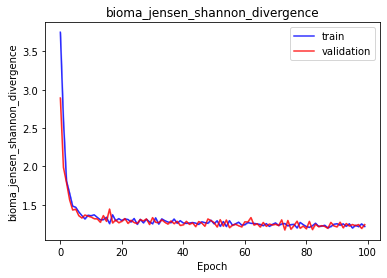

<b>domain_mse</b>: 12.4054 (min: 12.4054, max: 12.4054)

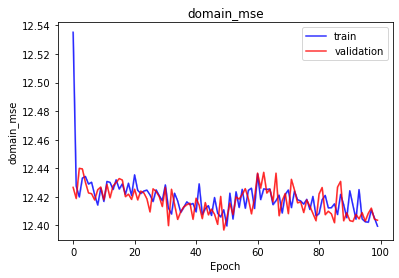

<b>domain_mae</b>: 0.9708 (min: 0.9708, max: 0.9708)

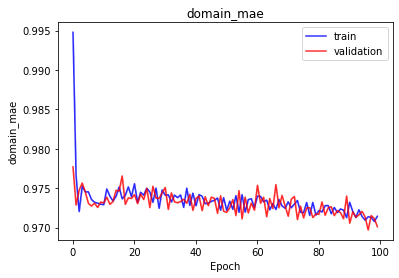

<b>domain_mape</b>: 31243290.0000 (min: 31243290.0000, max: 31243290.0000)

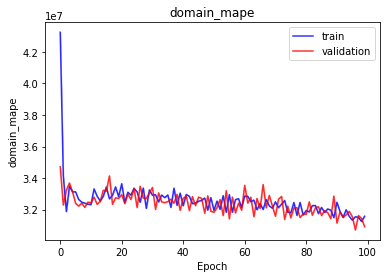

<b>domain_BrayCurtis</b>: 0.5317 (min: 0.5317, max: 0.5317)

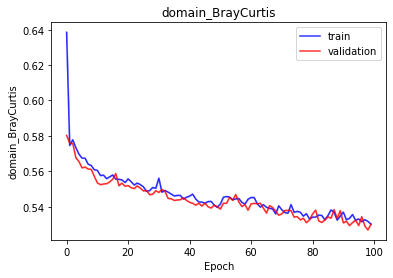

<b>domain_pearson_corr</b>: 0.4853 (min: 0.4853, max: 0.4853)

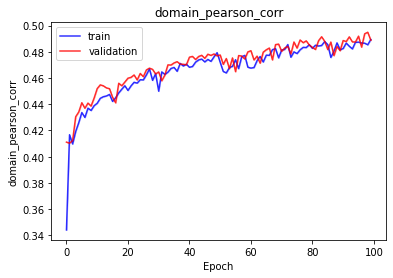

<b>domain_jensen_shannon_divergence</b>: 3.0248 (min: 3.0248, max: 3.0248)

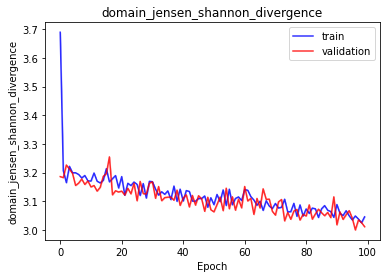

<b>latent_mae</b>: 0.0445 (min: 0.0445, max: 0.0445)

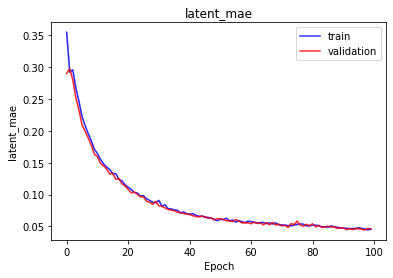

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.8114989995956421 | 0.8114989995956421 | 0.8114989995956421 |
| bioma_loss | 0.23529823124408722 | 0.23529823124408722 | 0.23529823124408722 |
| domain_loss | 0.5316999554634094 | 0.5316999554634094 | 0.5316999554634094 |
| latent_loss | 0.04450083151459694 | 0.04450083151459694 | 0.04450083151459694 |
| bioma_mse | 12.115653991699219 | 12.115653991699219 | 12.115653991699219 |
| bioma_mae | 0.9349135160446167 | 0.9349135160446167 | 0.9349135160446167 |
| bioma_mape | 13314804.0 | 13314804.0 | 13314804.0 |
| bioma_BrayCurtis | 0.23529823124408722 | 0.23529823124408722 | 0.23529823124408722 |
| bioma_pearson_corr | 0.8422833681106567 | 0.8422833681106567 | 0.8422833681106567 |
| bioma_jensen_shannon_divergence | 1.250961422920227 | 1.250961422920227 | 1.250961422920227 |
| domain_mse | 12.405364036560059 | 12.405364036560059 | 12.405364036560059 |
| domain_mae | 0.9707705974578857 | 0.9707705974578857 | 0.9707705974578857 |
| domain_mape | 31243290.0 | 31243290.0 | 31243290.0 |
| domain_BrayCurtis | 0.5316999554634094 | 0.5316999554634094 | 0.5316999554634094 |
| domain_pearson_corr | 0.4853494167327881 | 0.4853494167327881 | 0.4853494167327881 |
| domain_jensen_shannon_divergence | 3.0247554779052734 | 3.0247554779052734 | 3.0247554779052734 |
| latent_mae | 0.04450083151459694 | 0.04450083151459694 | 0.04450083151459694 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.6122101545333862 | 0.6122101545333862 | 0.6122101545333862 |
| pearson_corr | 0.4275018870830536 | 0.4275018870830536 | 0.4275018870830536 |
| jensen_shannon_divergence | 3.626304864883423 | 3.626304864883423 | 3.626304864883423 |


In [63]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Phylum

In [64]:
#nombres_metadatos = ["KCAL","PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","SUGR","FIBE","CALC","IRON","MAGN","PHOS","POTA","SODI","ZINC","COPP","SELE","VC","VB1","VB2","NIAC","VB6","FOLA","VB12","VARA","RET","BCAR","ACAR","CRYP","LYCO","LZ","ATOC","VK","CHOLE","SFAT","MFAT","PFAT","VITD","CHOLN"]
nombres_metadatos = ["PROT","TFAT","CARB","MOIS","ALC","CAFF","THEO","CALC","MAGN","POTA","ZINC","VC","VB1","VB6","VARA","ACAR","CRYP","LYCO","ATOC","VK","CHOLE","VITD"]
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = read_df(metadata_names=nombres_metadatos,otu_filename='resultados_ana/datos_otus_metadatos_filo/otus_filo_conMetadatos.csv',metadata_filename='resultados_ana/datos_otus_metadatos_filo/metadatos_nutrientes_filo.csv')

data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 15 |
| Bioma Autoencoder | b -> 512 -> 256 -> 15 -> 256 -> 512 -> b |
| Domain Autoencoder | d -> 32 -> 16 -> 15 -> 256 -> 512 -> b |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>88</b></p>

<b>loss</b>: 0.2026 (min: 0.2026, max: 0.2026)

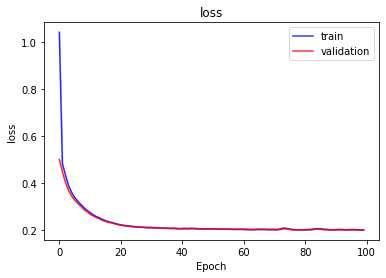

<b>bioma_loss</b>: 0.0995 (min: 0.0995, max: 0.0995)

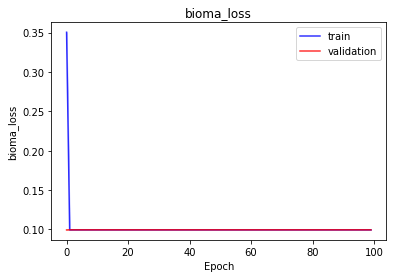

<b>domain_loss</b>: 0.0995 (min: 0.0995, max: 0.0995)

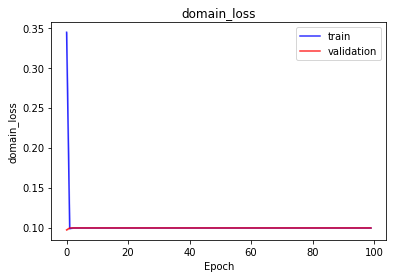

<b>latent_loss</b>: 0.0035 (min: 0.0035, max: 0.0035)

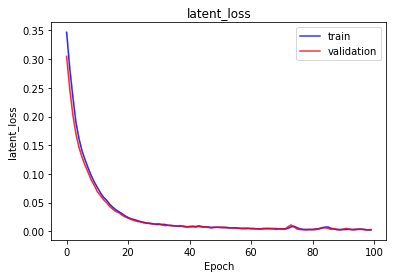

<b>bioma_mse</b>: 134845.0469 (min: 134845.0469, max: 134845.0469)

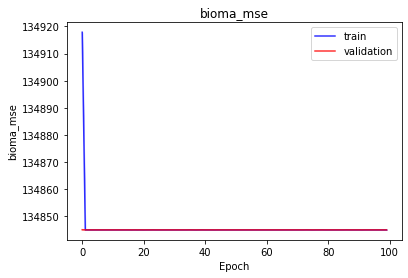

<b>bioma_mae</b>: 118.1727 (min: 118.1727, max: 118.1727)

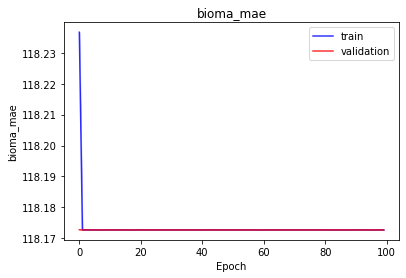

<b>bioma_mape</b>: 356179.4375 (min: 356179.4375, max: 356179.4375)

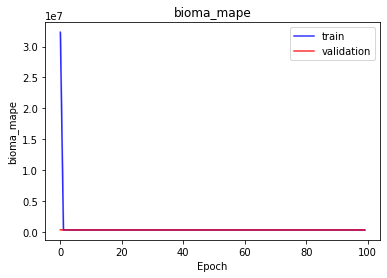

<b>bioma_BrayCurtis</b>: 0.0995 (min: 0.0995, max: 0.0995)

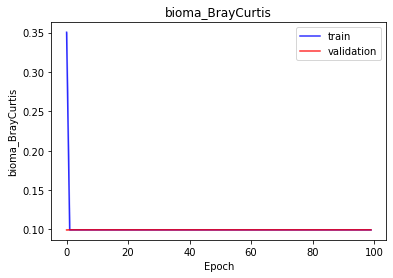

<b>bioma_pearson_corr</b>: 0.9778 (min: 0.9778, max: 0.9778)

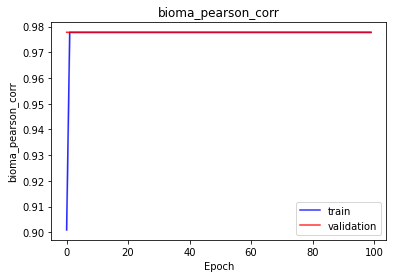

<b>bioma_jensen_shannon_divergence</b>: 0.8985 (min: 0.8985, max: 0.8985)

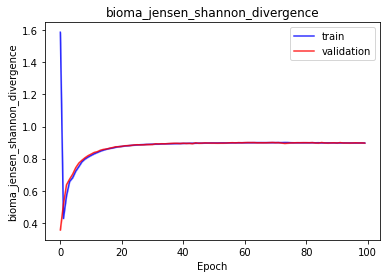

<b>domain_mse</b>: 134845.0469 (min: 134845.0469, max: 134845.0469)

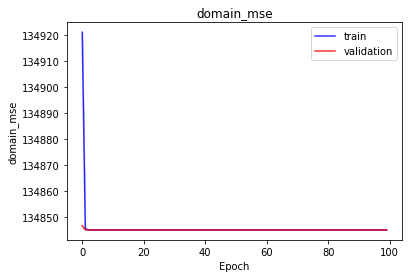

<b>domain_mae</b>: 118.1727 (min: 118.1727, max: 118.1727)

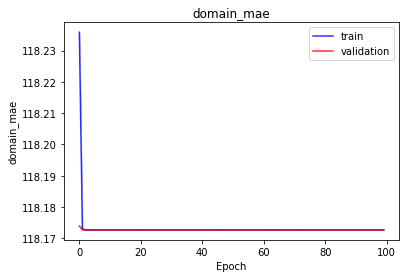

<b>domain_mape</b>: 356179.4375 (min: 356179.4375, max: 356179.4375)

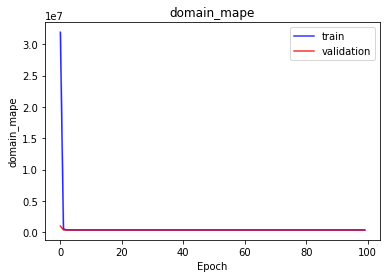

<b>domain_BrayCurtis</b>: 0.0995 (min: 0.0995, max: 0.0995)

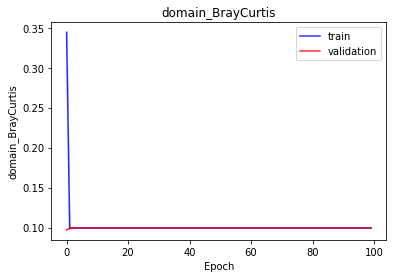

<b>domain_pearson_corr</b>: 0.9778 (min: 0.9778, max: 0.9778)

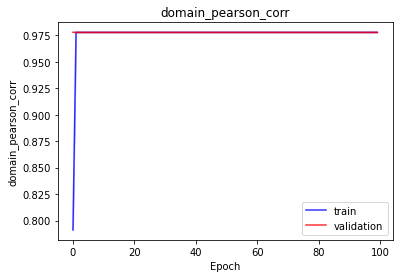

<b>domain_jensen_shannon_divergence</b>: 0.8983 (min: 0.8983, max: 0.8983)

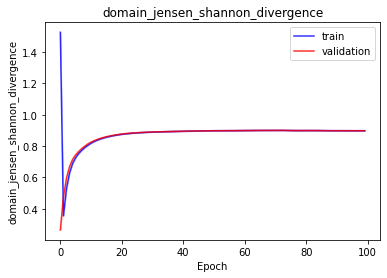

<b>latent_mae</b>: 0.0035 (min: 0.0035, max: 0.0035)

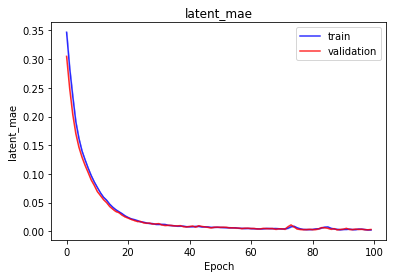

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.20256230235099792 | 0.20256230235099792 | 0.20256230235099792 |
| bioma_loss | 0.09951115399599075 | 0.09951115399599075 | 0.09951115399599075 |
| domain_loss | 0.09951115399599075 | 0.09951115399599075 | 0.09951115399599075 |
| latent_loss | 0.0035399743355810642 | 0.0035399743355810642 | 0.0035399743355810642 |
| bioma_mse | 134845.046875 | 134845.046875 | 134845.046875 |
| bioma_mae | 118.17271423339844 | 118.17271423339844 | 118.17271423339844 |
| bioma_mape | 356179.4375 | 356179.4375 | 356179.4375 |
| bioma_BrayCurtis | 0.09951115399599075 | 0.09951115399599075 | 0.09951115399599075 |
| bioma_pearson_corr | 0.9777647852897644 | 0.9777647852897644 | 0.9777647852897644 |
| bioma_jensen_shannon_divergence | 0.8985211849212646 | 0.8985211849212646 | 0.8985211849212646 |
| domain_mse | 134845.046875 | 134845.046875 | 134845.046875 |
| domain_mae | 118.17271423339844 | 118.17271423339844 | 118.17271423339844 |
| domain_mape | 356179.4375 | 356179.4375 | 356179.4375 |
| domain_BrayCurtis | 0.09951115399599075 | 0.09951115399599075 | 0.09951115399599075 |
| domain_pearson_corr | 0.9777647852897644 | 0.9777647852897644 | 0.9777647852897644 |
| domain_jensen_shannon_divergence | 0.898259162902832 | 0.898259162902832 | 0.898259162902832 |
| latent_mae | 0.0035399743355810642 | 0.0035399743355810642 | 0.0035399743355810642 |


*************

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.11989408731460571 | 0.11989408731460571 | 0.11989408731460571 |
| pearson_corr | 0.9541983008384705 | 0.9541983008384705 | 0.9541983008384705 |
| jensen_shannon_divergence | 1.1193448305130005 | 1.1193448305130005 | 1.1193448305130005 |


In [65]:
experiment_metrics, models, results = perform_experiment_2_mod(cv_folds=0,
                                                               epochs=100,
                                                               batch_size=64,
                                                               learning_rate=0.001,
                                                               optimizer=optimizers.Adam,
                                                               learning_rate_scheduler=None,
                                                               input_transform=Percentage,
                                                               output_transform=tf.keras.layers.Softmax,
                                                               reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None),
                                                               latent_space=15,
                                                               layers=[512,256],
                                                               activation='tanh',
                                                               activation_latent='tanh',
                                                               data_microbioma_train=data_microbioma_train,
                                                               data_domain_train=data_domain_train,
                                                               show_results=True,
                                                               device='/CPU:0')
    
#Guardamos el modelo, encoder y decoder
model, encoder, _ ,decoder = models[0]
  
def model_fn_latent():
    in_layer = layers.Input(shape=(data_domain_train.shape[1],))
    net = layers.Dense(128, activation='sigmoid')(in_layer)
    net = layers.Dense(64, activation='sigmoid')(net)
    net = layers.Dense(32, activation='sigmoid')(net)
    net = layers.Dense(16, activation='sigmoid')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation='tanh')(net)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model
    
#funcion del modelado -- por ahora lo dejaremos asi, y voy a habalr con ella par aver que cambio, que tuneo
latent_train = encoder.predict(data_microbioma_train)
    
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                                                  latent_train,
                                                  latent_train,
                                                  data_domain_train,
                                                  data_domain_train,
                                                  epochs=100,
                                                  batch_size=16,
                                                  verbose=-1)

#evaluamos el modelo
latent_test = encoder.predict(data_microbioma_test)
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, otu_columns, data_microbioma_test, data_domain_test)

### Kingdom

In [ ]:
????????????????Lo hago?